# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



Functions to evaluate a single input sequence, get the attention weights and plot them:

In [3]:
import matplotlib.ticker as ticker

def evaluate(seq_in, attention, model):
    # Get layers from model
    encoder_lstm = model.get_layer('encoder_lstm')
    decoder_lstm = model.get_layer('decoder_lstm')
    decoder_dense = model.get_layer('decoder_dense')
    
    attention_weights_plot = np.zeros((n_timesteps_in, n_timesteps_in))

    sequence = one_hot_encode(seq_in, n_features)
    encoder_inputs = np.array(sequence).reshape(1, n_timesteps_in, -1)
    encoder_inputs = tf.convert_to_tensor(encoder_inputs, dtype=tf.float32)

    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

    # initial context vector is the states of the encoder
    states = [state_h, state_c]

    all_outputs = []

    # Prepare decoder input data that just contains the start character 0
    # Note that we made it a constant one-hot-encoded in the model
    decoder_input_data = np.zeros((1, 1, n_features))
    decoder_input_data[:, 0, 0] = 1 

    inputs = decoder_input_data
    
    # Initial hiden state
    decoder_outputs = state_h

    # decoder will only process one timestep at a time.
    for t in range(n_timesteps_in):
        # pay attention
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)

        # Store the attention weights
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_weights_plot[t] = attention_weights.numpy()

        decoder_outputs = tf.expand_dims(decoder_outputs, 1)

        context_vector = tf.expand_dims(context_vector, 1)
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # passing the concatenated vector to the LSTM
        # Run the decoder on one timestep
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Store the current prediction (we will concatenate all predictions later)
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
    
        # Reinject the outputs as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    # Concatenate all predictions such as [batch_size, timesteps, features]
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_out=one_hot_decode(decoder_outputs[0])

    return seq_in, seq_out, attention_weights_plot


# function for plotting the attention weights
def plot_attention(attention_weights, sequence, predicted_sequence):
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_weights)

    fontdict = {'fontsize': 9}

    ax.set_xticklabels([''] + sequence, fontdict = fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    ax.set_xlabel('Input sequence')
    ax.set_ylabel('Output sequence')
    plt.suptitle('Attention weights')

    plt.show()


def evaluate_plot_attention(example_sequence, attention, model):    
    # Run the model to get the attention weights and the prediction
    seq_in, seq_out, attention_weights = evaluate(example_sequence, attention, model)
    attention_weights = attention_weights[:len(seq_out), :len(seq_in)]
    
    print(f'Input sequence: {example_sequence}')
    print(f'Expected output: {list(reversed(example_sequence))}')
    print(f'Model output: {seq_out}')
    
    # Plot the attention weights for each element of the sequence
    plot_attention(attention_weights, seq_in, seq_out)


In [4]:
# Generate dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200

X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features)

# Generate an example sequence
example_sequence = generate_sequence(n_timesteps_in, n_features)

print('Example sequence')
print(example_sequence)

Example sequence
[19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]


## Luong Dot attention

Training parameters:
- Batch size: 100
- RNN units: 100

In [5]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model = build_attention_model(attention, batch_size, rnn_units)

2022-01-06 20:36:24.123467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 20:36:24.131792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 20:36:24.132447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-06 20:36:24.133525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-01-06 20:36:46.852525: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-06 20:38:23.988966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 [==============================] - 136s 2s/step - loss: 2.9673 - accuracy: 0.0525 - val_loss: 2.9479 - val_accuracy: 0.0554
Epoch 2/50
18/18 [==============================] - 3s 187ms/step - loss: 2.9454 - accuracy: 0.0584 - val_loss: 2.9425 - val_accuracy: 0.0669
Epoch 3/50
18/18 [==============================] - 3s 189ms/step - loss: 2.9397 - accuracy: 0.0630 - val_loss: 2.9353 - val_accuracy: 0.0679
Epoch 4/50
18/18 [==============================] - 3s 187ms/step - loss: 2.9302 - accuracy: 0.0726 - val_loss: 2.9247 - val_accuracy: 0.0755
Epoch 5/50
18/18 [==============================] - 4s 205ms/step - loss: 2.9195 - accuracy: 0.0792 - val_loss: 2.9167 - val_accuracy: 0.0828
Epoch 6/50
18/18 [==============================] - 3s 188ms/step - loss: 2.9112 - accuracy: 0.0838 - val_loss: 2.9051 - val_accuracy: 0.0857
Epoch 7/50
18/18 [==============================] - 3s 188ms/step - loss: 2.9011 - accuracy: 0.0871 - val_loss: 2.8979 - val_accuracy: 0.0910
Epoch 8/50
18/18 [

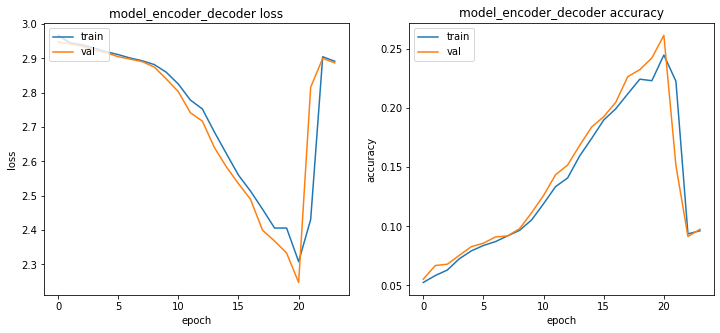

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [14, 14, 9, 9, 9, 9, 9, 9, 14, 7, 7, 1, 1, 1, 1, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 19, 19, 19, 19, 19, 19, 11, 6, 6, 6, 6, 6, 6, 6, 16, 14, 14, 14, 14, 14, 14, 12, 12, 12, 12, 12, 17,

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


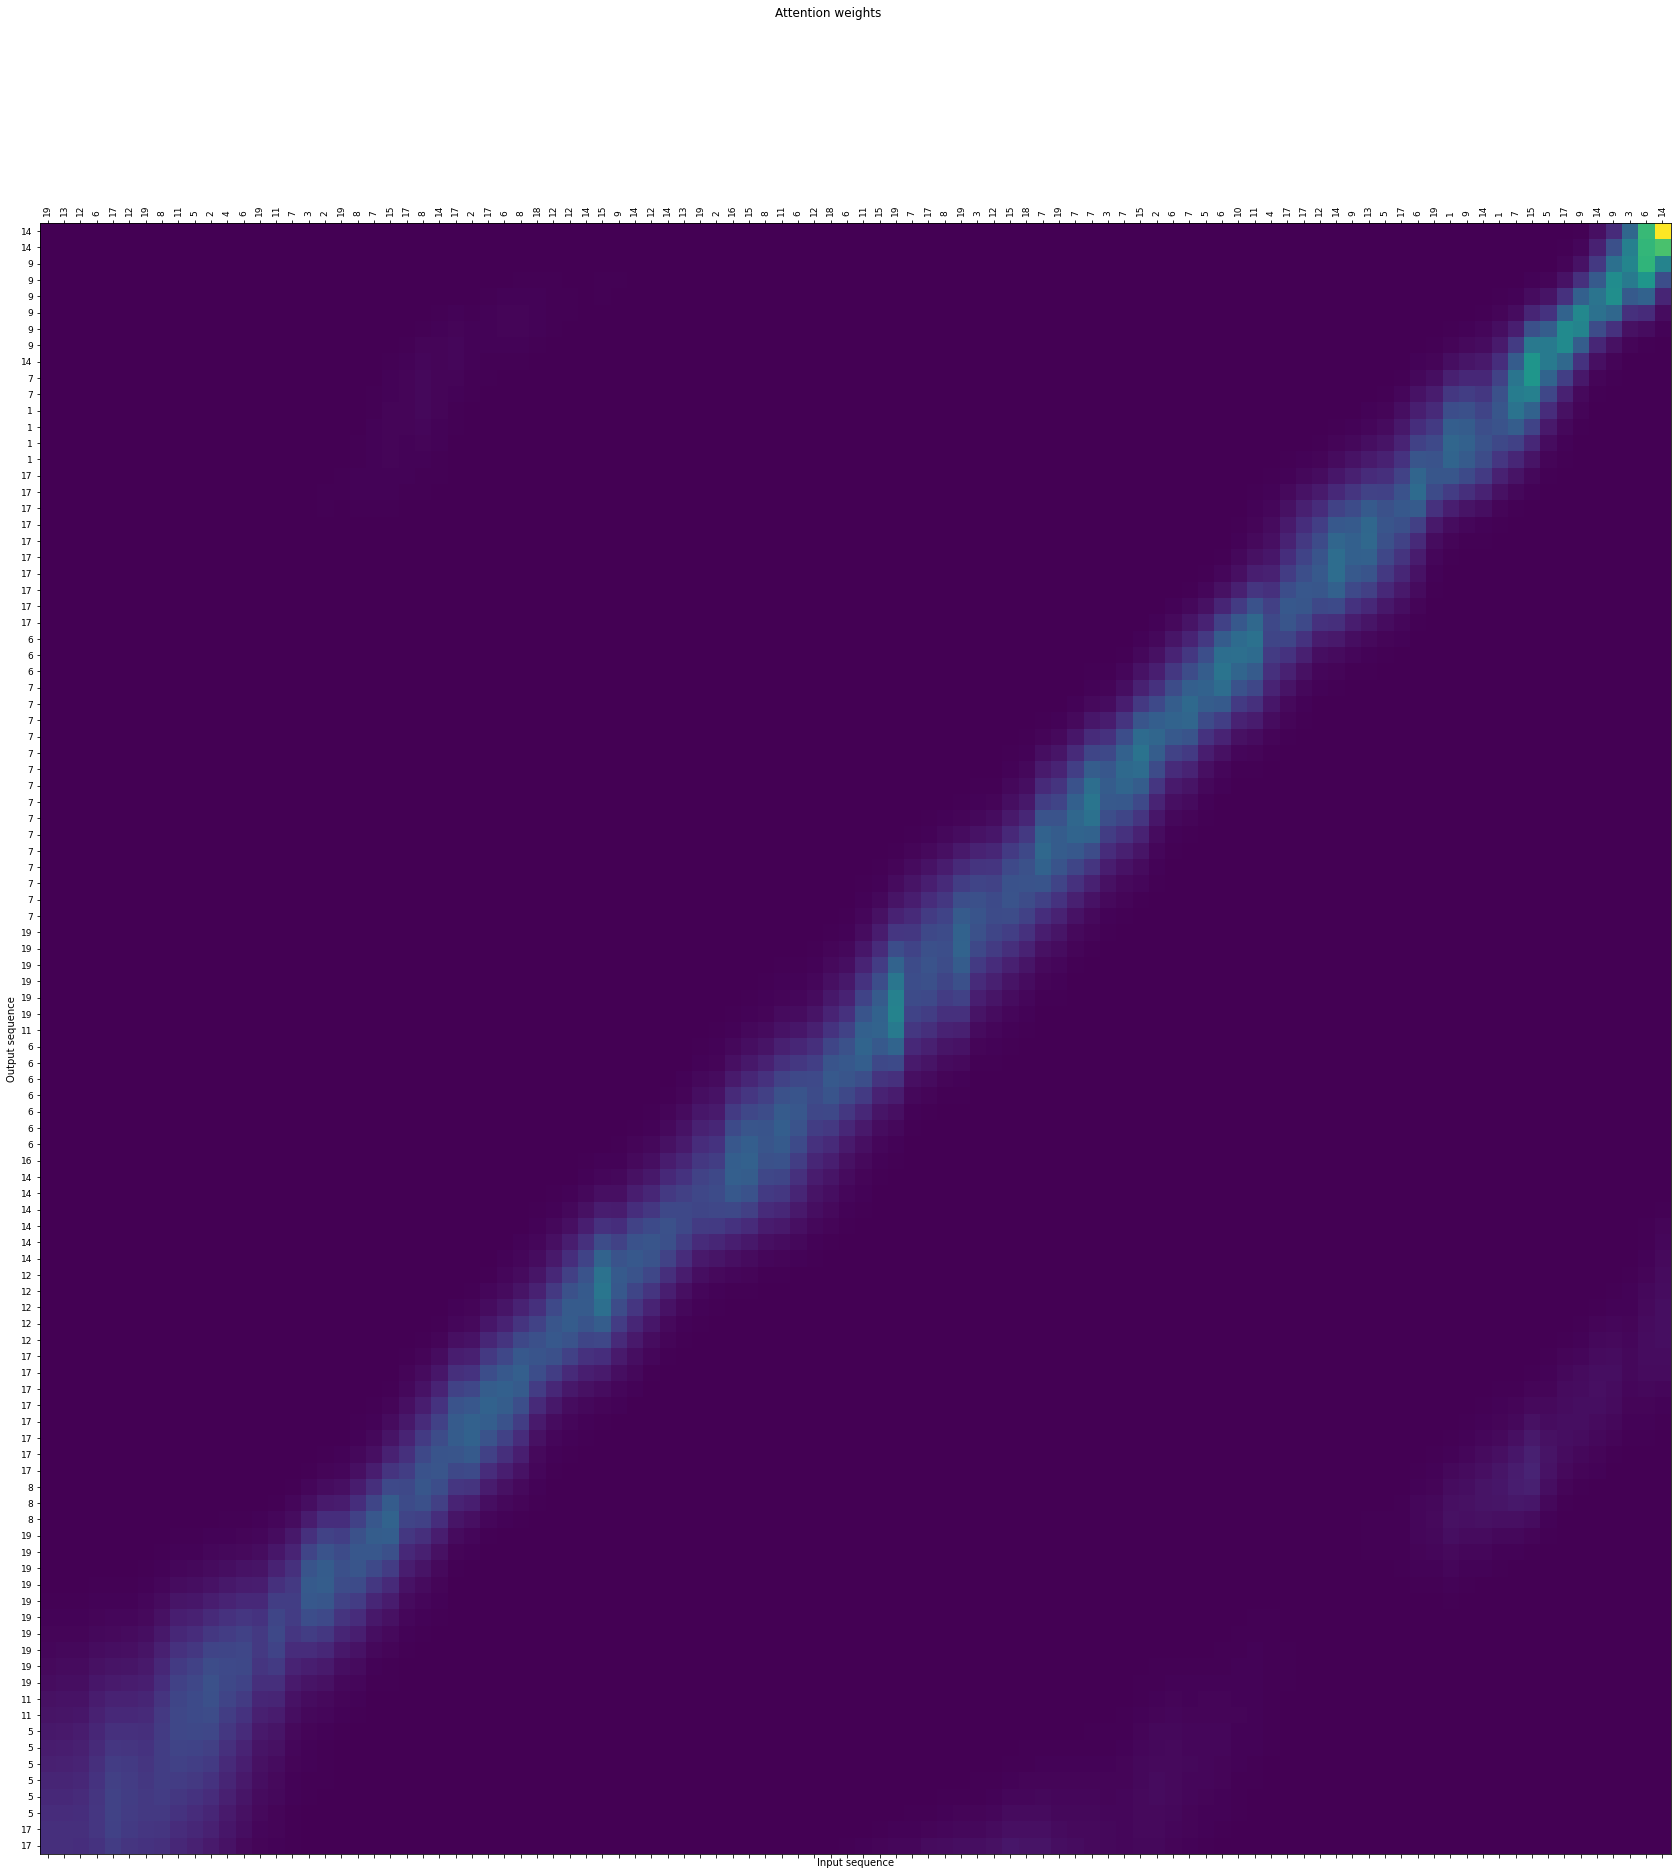

In [6]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

Training parameters:
- Batch size: 50
- RNN units: 100

In [7]:
# training parameters
batch_size = 50

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
36/36 [==============================] - 144s 1s/step - loss: 2.9555 - accuracy: 0.0545 - val_loss: 2.9452 - val_accuracy: 0.0539
Epoch 2/50
36/36 [==============================] - 7s 185ms/step - loss: 2.9404 - accuracy: 0.0622 - val_loss: 2.9327 - val_accuracy: 0.0682
Epoch 3/50
36/36 [==============================] - 7s 190ms/step - loss: 2.9263 - accuracy: 0.0755 - val_loss: 2.9176 - val_accuracy: 0.0811
Epoch 4/50
36/36 [==============================] - 7s 183ms/step - loss: 2.9095 - accuracy: 0.0842 - val_loss: 2.8988 - val_accuracy: 0.0874
Epoch 5/50
36/36 [==============================] - 7s 189ms/step - loss: 2.8896 - accuracy: 0.0931 - val_loss: 2.8756 - val_accuracy: 0.0954
Epoch 6/50
36/36 [==============================] - 7s 197ms/step - loss: 2.8468 - accuracy: 0.1096 - val_loss: 2.8112 - val_accuracy: 0.1228
Epoch 7/50
36/36 [==============================] - 7s 185ms/step - loss: 2.7780 - accuracy: 0.1318 - val_loss: 2.7264 - val_accuracy: 0.1462
Epoch 8

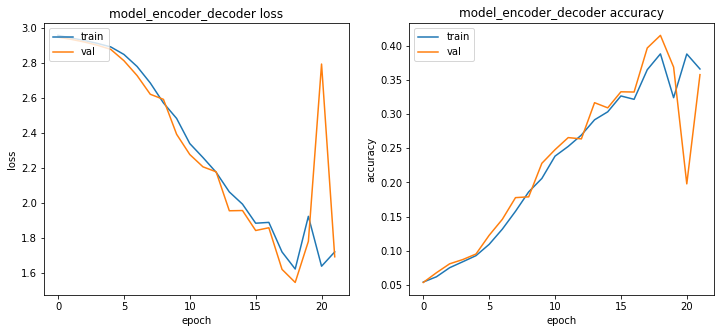

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [3, 6, 3, 9, 9, 9, 9, 17, 7, 7, 1, 1, 1, 1, 1, 19, 19, 5, 5, 9, 9, 14, 17, 17, 17, 11, 11, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 19, 19, 19, 19, 19, 17, 17, 17, 7, 15, 6, 6, 6, 11, 11, 12, 8, 15, 15, 15, 19, 14, 14, 14, 14, 14, 14, 12, 12, 12

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


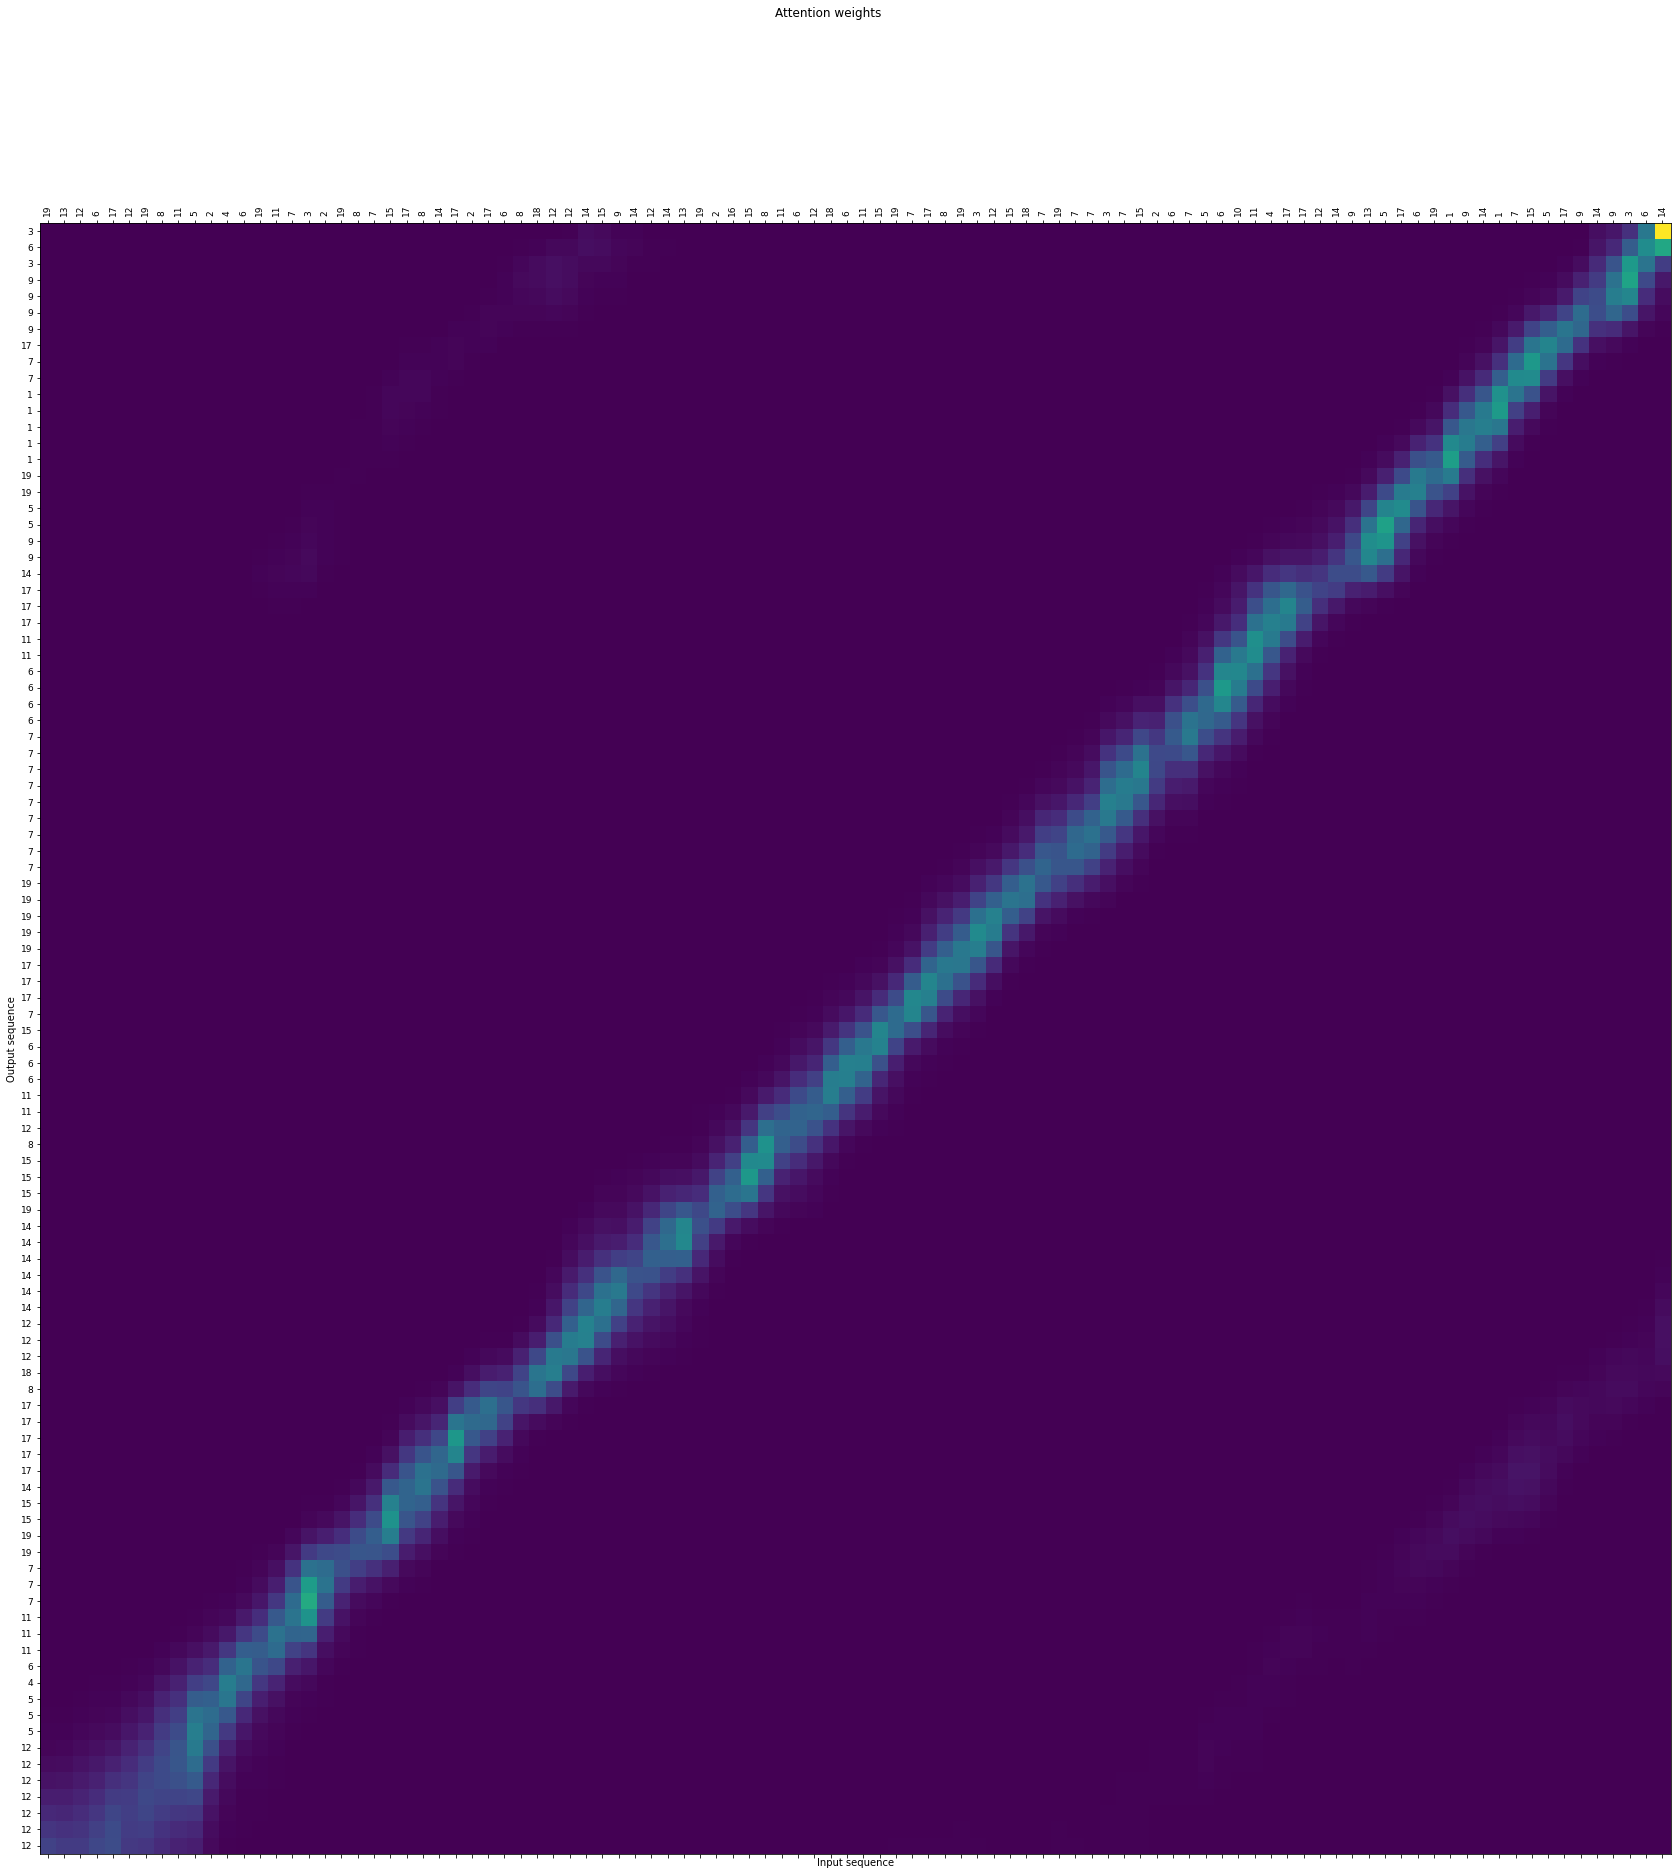

In [8]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

Training parameters:
- Batch size: 20
- RNN units: 80

In [9]:
# training parameters
batch_size = 20

# model parameters
rnn_units = 80

# attention model
attention = LuongDotAttention()
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
90/90 [==============================] - 150s 500ms/step - loss: 2.9508 - accuracy: 0.0577 - val_loss: 2.9390 - val_accuracy: 0.0659
Epoch 2/50
90/90 [==============================] - 16s 173ms/step - loss: 2.9243 - accuracy: 0.0771 - val_loss: 2.9142 - val_accuracy: 0.0814
Epoch 3/50
90/90 [==============================] - 16s 180ms/step - loss: 2.9023 - accuracy: 0.0880 - val_loss: 2.8903 - val_accuracy: 0.0930
Epoch 4/50
90/90 [==============================] - 16s 176ms/step - loss: 2.8598 - accuracy: 0.1052 - val_loss: 2.8057 - val_accuracy: 0.1240
Epoch 5/50
90/90 [==============================] - 17s 185ms/step - loss: 2.7212 - accuracy: 0.1501 - val_loss: 2.6113 - val_accuracy: 0.1804
Epoch 6/50
90/90 [==============================] - 15s 172ms/step - loss: 2.5346 - accuracy: 0.1978 - val_loss: 2.4007 - val_accuracy: 0.2270
Epoch 7/50
90/90 [==============================] - 16s 176ms/step - loss: 2.3597 - accuracy: 0.2359 - val_loss: 2.2021 - val_accuracy: 0.271

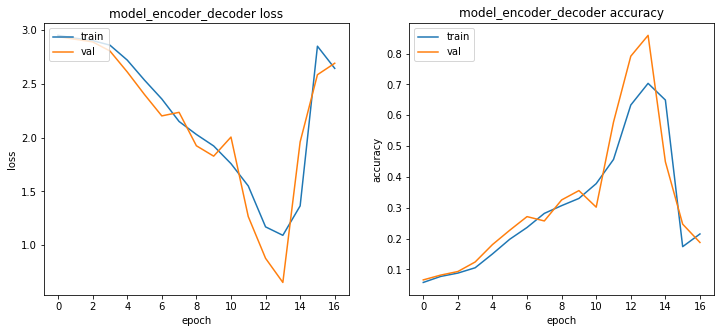

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [14, 14, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 7, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 13, 13, 14, 14, 14, 9, 15, 14, 12, 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


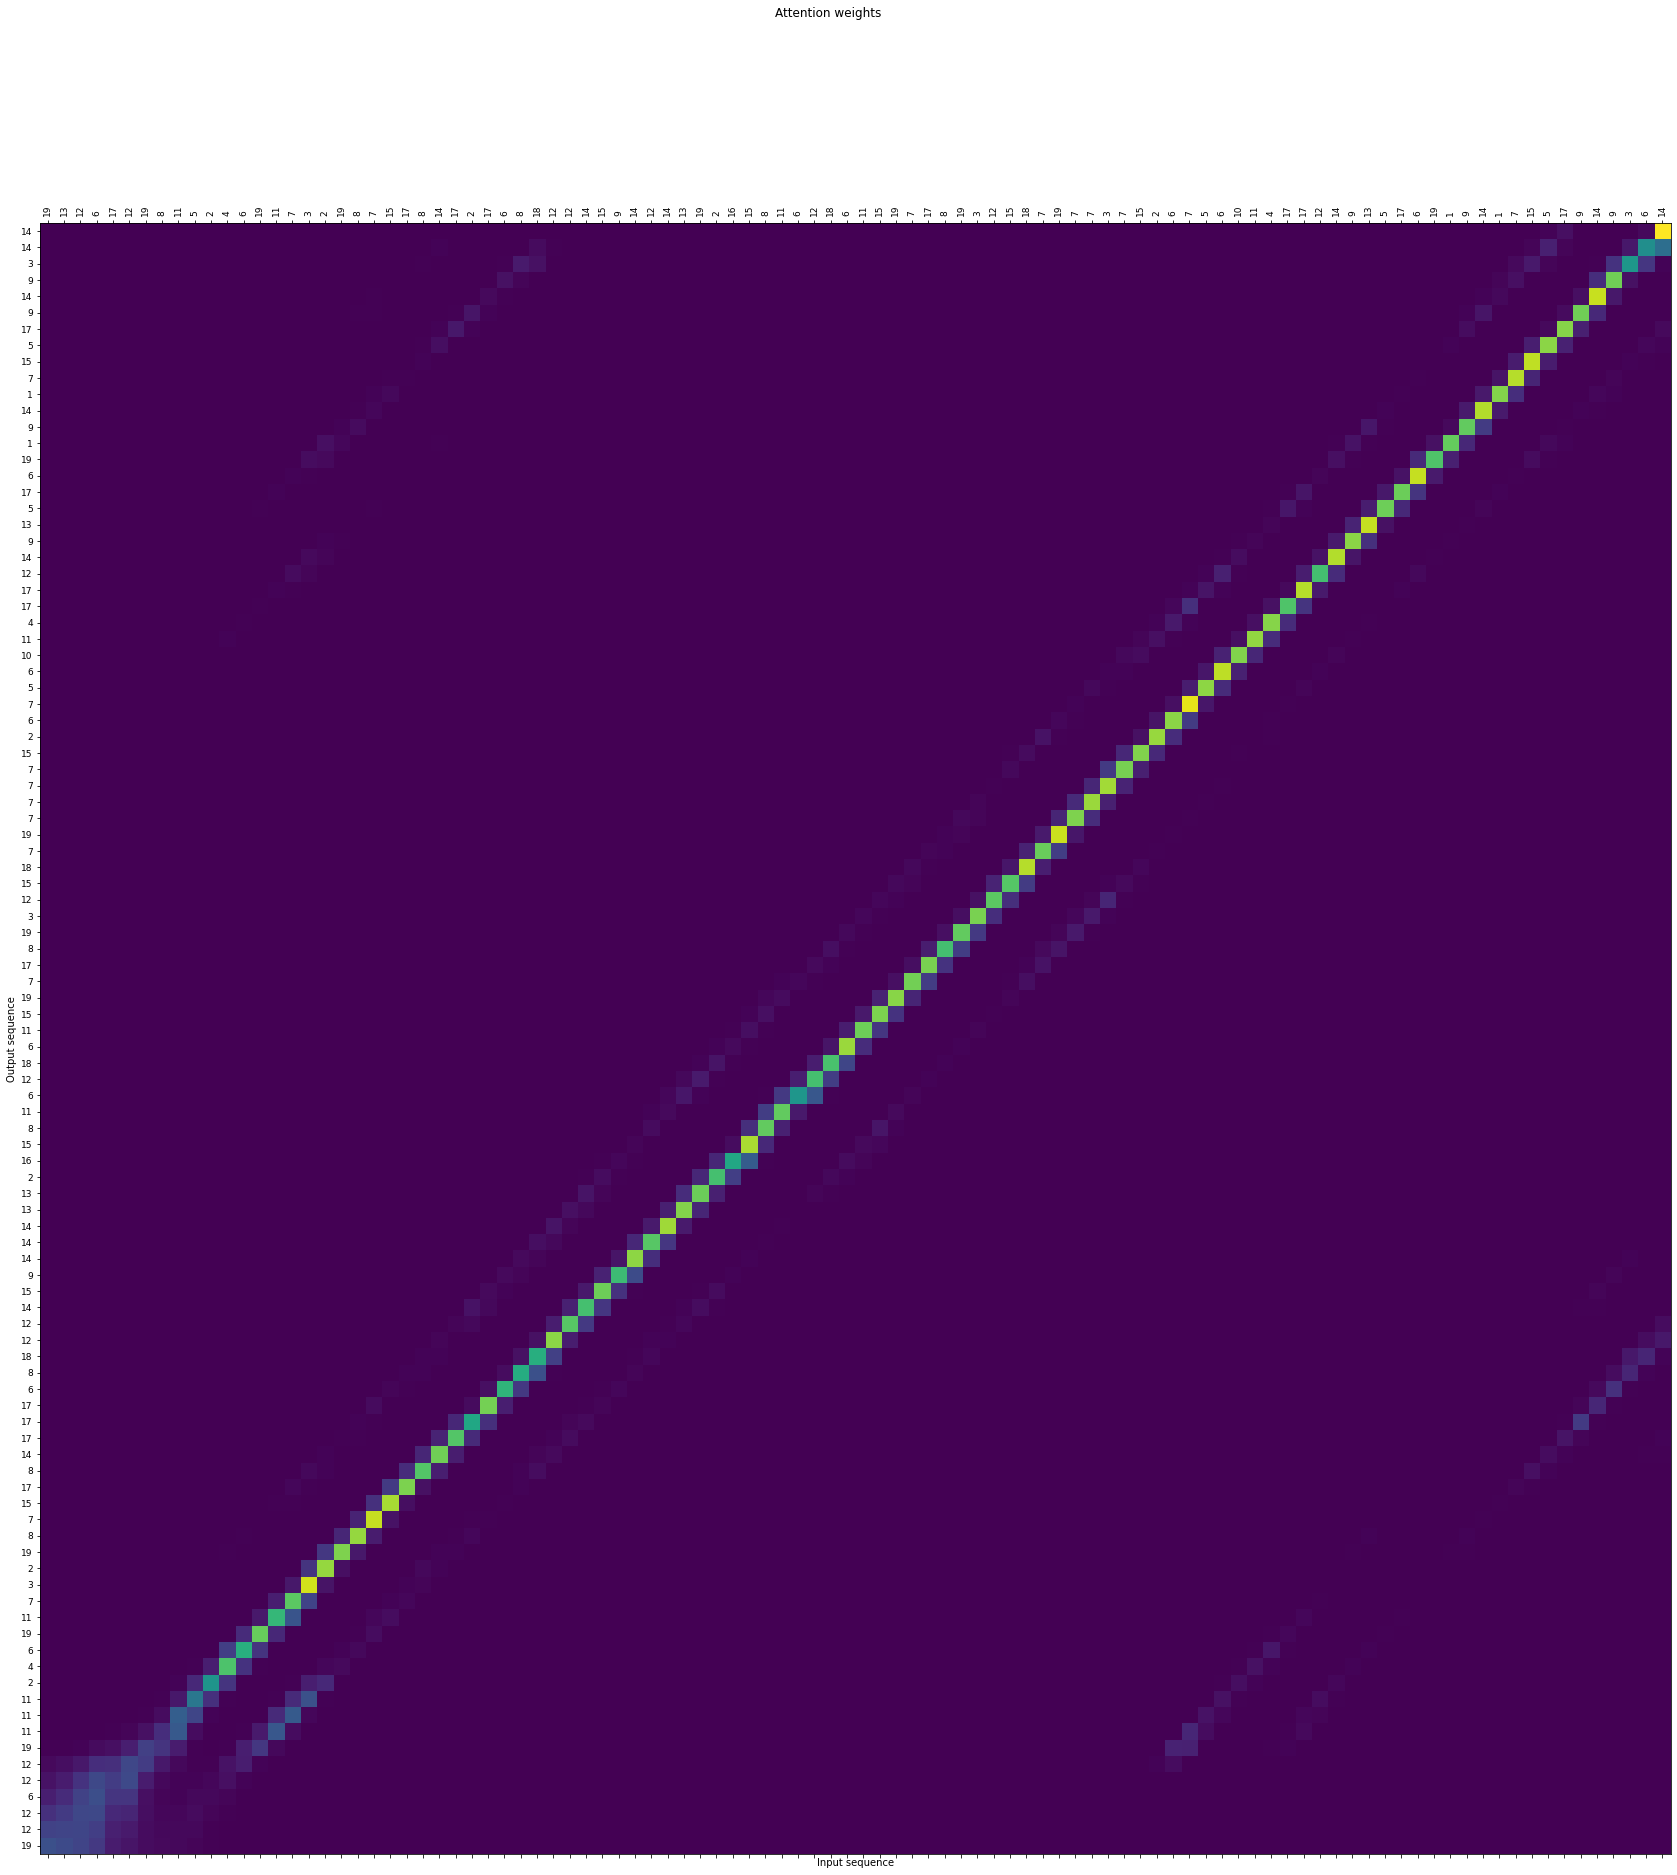

In [10]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

## Bahdanau attention

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Training parameters:
- Batch size: 100
- RNN units: 100
- Attention units: 50

In [12]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
units = 50
attention = BahdanauAttention(units)
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 147s 2s/step - loss: 2.9654 - accuracy: 0.0555 - val_loss: 2.9494 - val_accuracy: 0.0616
Epoch 2/50
18/18 [==============================] - 4s 217ms/step - loss: 2.9453 - accuracy: 0.0573 - val_loss: 2.9429 - val_accuracy: 0.0588
Epoch 3/50
18/18 [==============================] - 4s 209ms/step - loss: 2.9408 - accuracy: 0.0662 - val_loss: 2.9382 - val_accuracy: 0.0644
Epoch 4/50
18/18 [==============================] - 4s 209ms/step - loss: 2.9335 - accuracy: 0.0705 - val_loss: 2.9288 - val_accuracy: 0.0735
Epoch 5/50
18/18 [==============================] - 4s 215ms/step - loss: 2.9252 - accuracy: 0.0769 - val_loss: 2.9198 - val_accuracy: 0.0772
Epoch 6/50
18/18 [==============================] - 4s 210ms/step - loss: 2.9162 - accuracy: 0.0817 - val_loss: 2.9123 - val_accuracy: 0.0823
Epoch 7/50
18/18 [==============================] - 4s 209ms/step - loss: 2.9082 - accuracy: 0.0858 - val_loss: 2.9052 - val_accuracy: 0.0859
Epoch 8

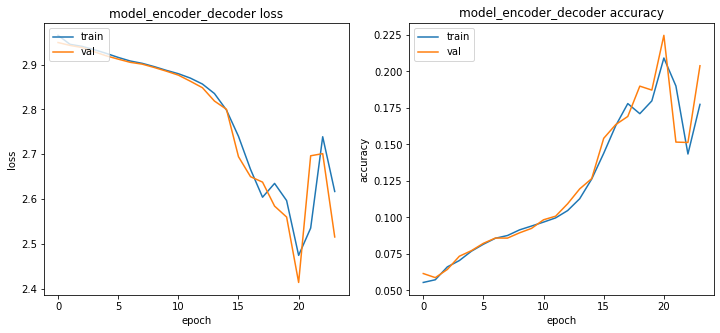

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [14, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 17, 17, 14, 14, 17, 17, 17, 17, 6, 6, 6, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 12, 12, 12, 12, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


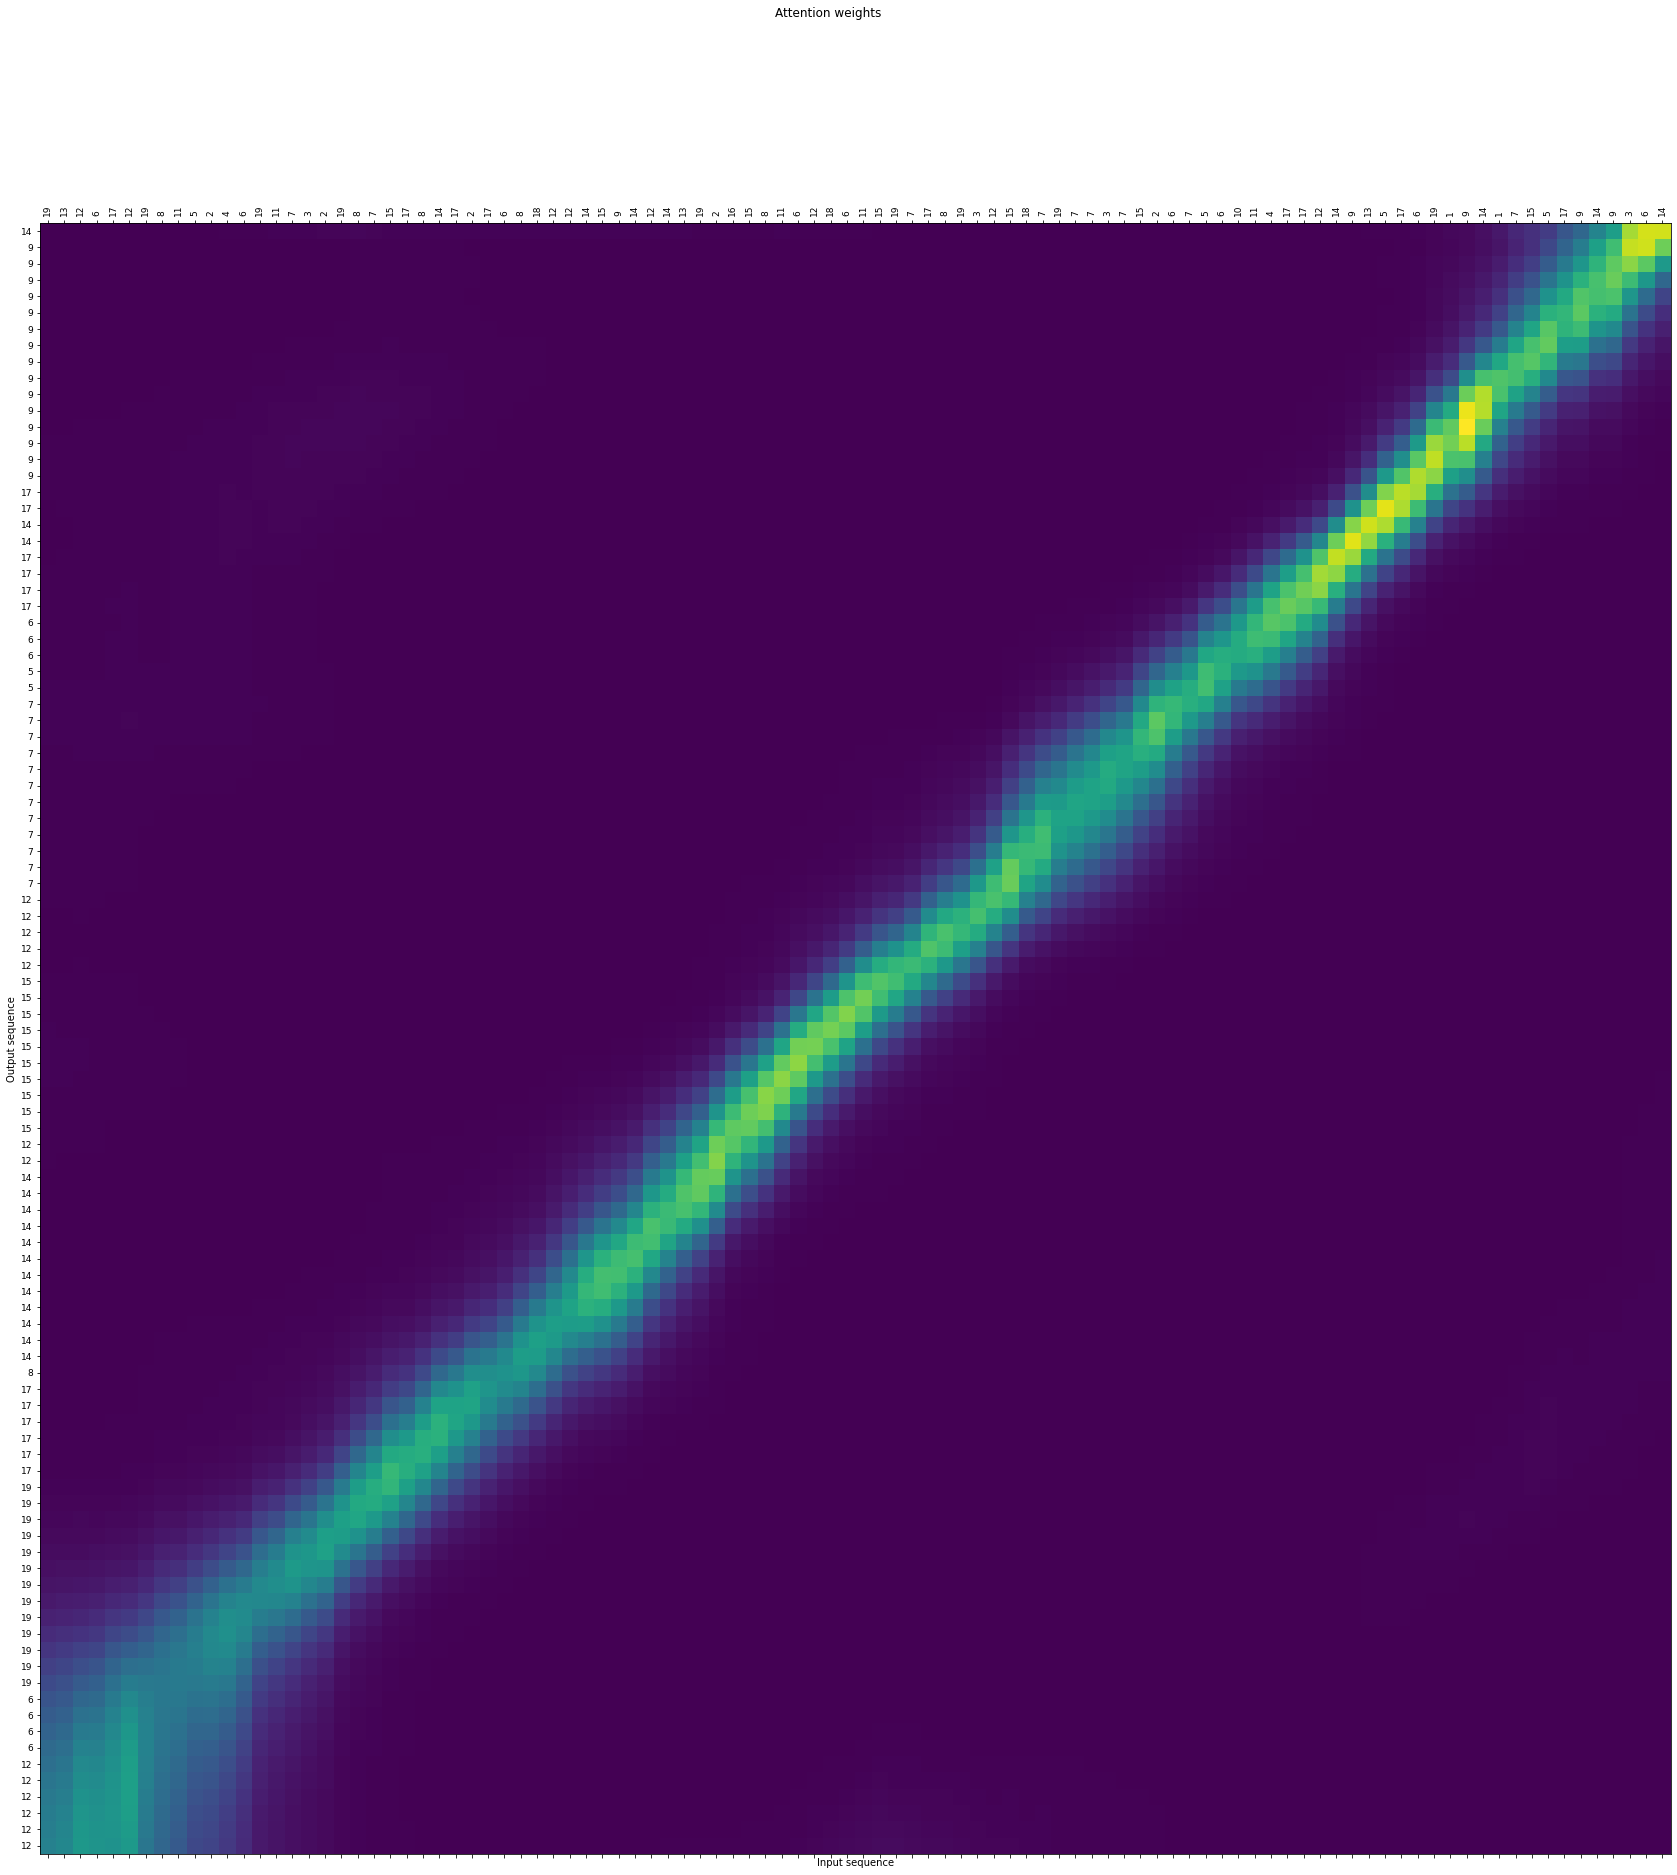

In [13]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

Training parameters:
- Batch size: 50
- RNN units: 100
- Attention units: 50

In [14]:
# training parameters
batch_size = 50

# model parameters
rnn_units = 100

# attention model
units = 50
attention = BahdanauAttention(units)
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
36/36 [==============================] - 150s 1s/step - loss: 2.9560 - accuracy: 0.0535 - val_loss: 2.9443 - val_accuracy: 0.0539
Epoch 2/50
36/36 [==============================] - 7s 202ms/step - loss: 2.9402 - accuracy: 0.0635 - val_loss: 2.9329 - val_accuracy: 0.0725
Epoch 3/50
36/36 [==============================] - 8s 210ms/step - loss: 2.9235 - accuracy: 0.0770 - val_loss: 2.9162 - val_accuracy: 0.0801
Epoch 4/50
36/36 [==============================] - 8s 215ms/step - loss: 2.9086 - accuracy: 0.0859 - val_loss: 2.9011 - val_accuracy: 0.0888
Epoch 5/50
36/36 [==============================] - 7s 202ms/step - loss: 2.8945 - accuracy: 0.0918 - val_loss: 2.8909 - val_accuracy: 0.0930
Epoch 6/50
36/36 [==============================] - 7s 206ms/step - loss: 2.8792 - accuracy: 0.0976 - val_loss: 2.8726 - val_accuracy: 0.1009
Epoch 7/50
36/36 [==============================] - 8s 214ms/step - loss: 2.8562 - accuracy: 0.1067 - val_loss: 2.8410 - val_accuracy: 0.1109
Epoch 8

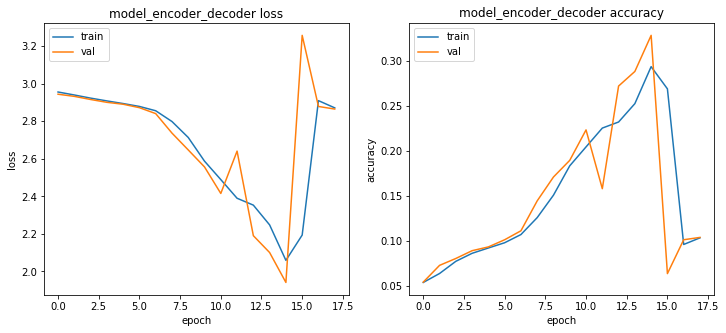

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [9, 14, 14, 14, 9, 9, 9, 5, 14, 14, 1, 1, 1, 1, 1, 17, 17, 13, 13, 17, 17, 17, 17, 17, 17, 11, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 19, 19, 19, 19, 19, 19, 19, 19, 6, 6, 6, 6, 6, 6, 6, 12, 16, 16, 16, 14, 14, 14, 14, 14, 14, 14, 14, 12

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


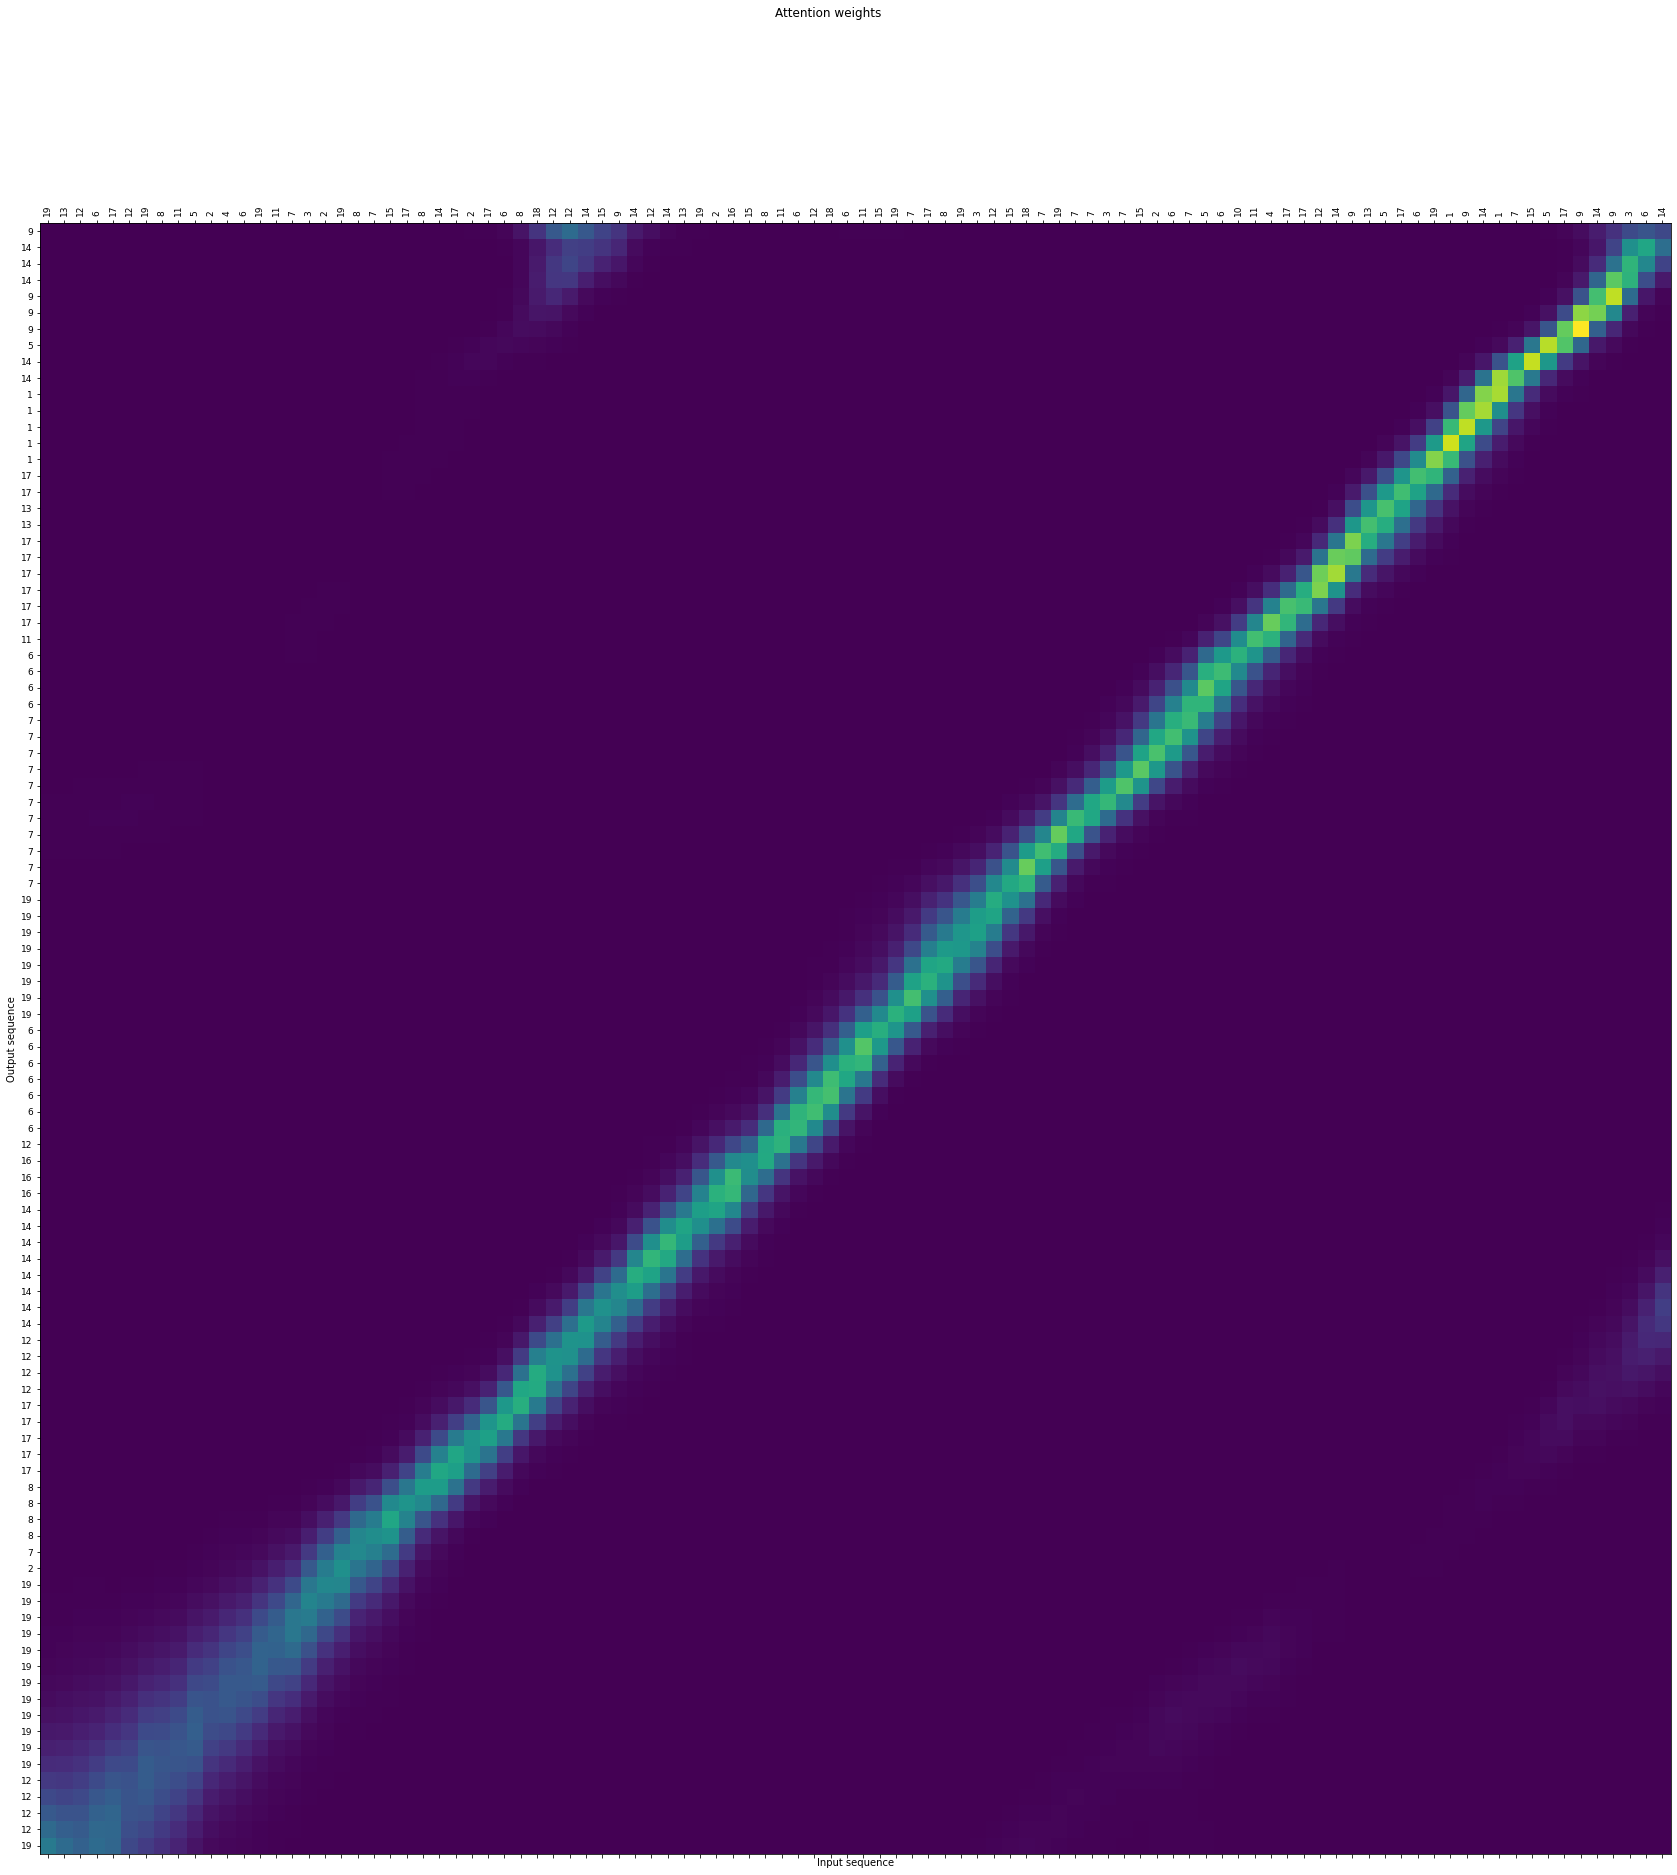

In [15]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

Training parameters:
- Batch size: 20
- RNN units: 100
- Attention units: 40

In [16]:
# training parameters
batch_size = 20

# model parameters
rnn_units = 100

# attention model
units = 40
attention = BahdanauAttention(units)
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
90/90 [==============================] - 160s 534ms/step - loss: 2.9485 - accuracy: 0.0584 - val_loss: 2.9345 - val_accuracy: 0.0658
Epoch 2/50
90/90 [==============================] - 19s 209ms/step - loss: 2.9184 - accuracy: 0.0796 - val_loss: 2.8999 - val_accuracy: 0.0901
Epoch 3/50
90/90 [==============================] - 18s 201ms/step - loss: 2.8890 - accuracy: 0.0926 - val_loss: 2.8720 - val_accuracy: 0.0995
Epoch 4/50
90/90 [==============================] - 19s 206ms/step - loss: 2.8513 - accuracy: 0.1071 - val_loss: 2.8085 - val_accuracy: 0.1216
Epoch 5/50
90/90 [==============================] - 18s 204ms/step - loss: 2.6851 - accuracy: 0.1562 - val_loss: 2.5495 - val_accuracy: 0.1920
Epoch 6/50
90/90 [==============================] - 19s 208ms/step - loss: 2.4600 - accuracy: 0.2085 - val_loss: 2.2786 - val_accuracy: 0.2519
Epoch 7/50
90/90 [==============================] - 19s 206ms/step - loss: 2.2522 - accuracy: 0.2511 - val_loss: 2.2922 - val_accuracy: 0.239

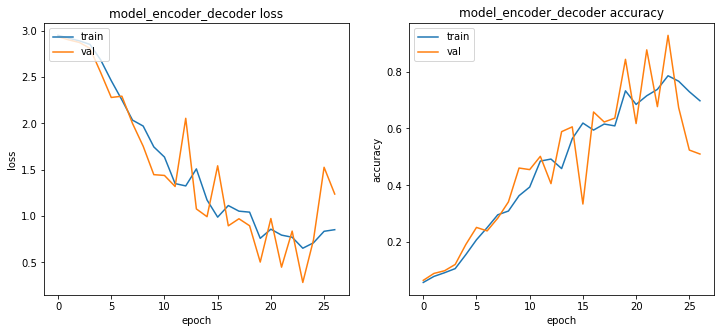

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 7, 19, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


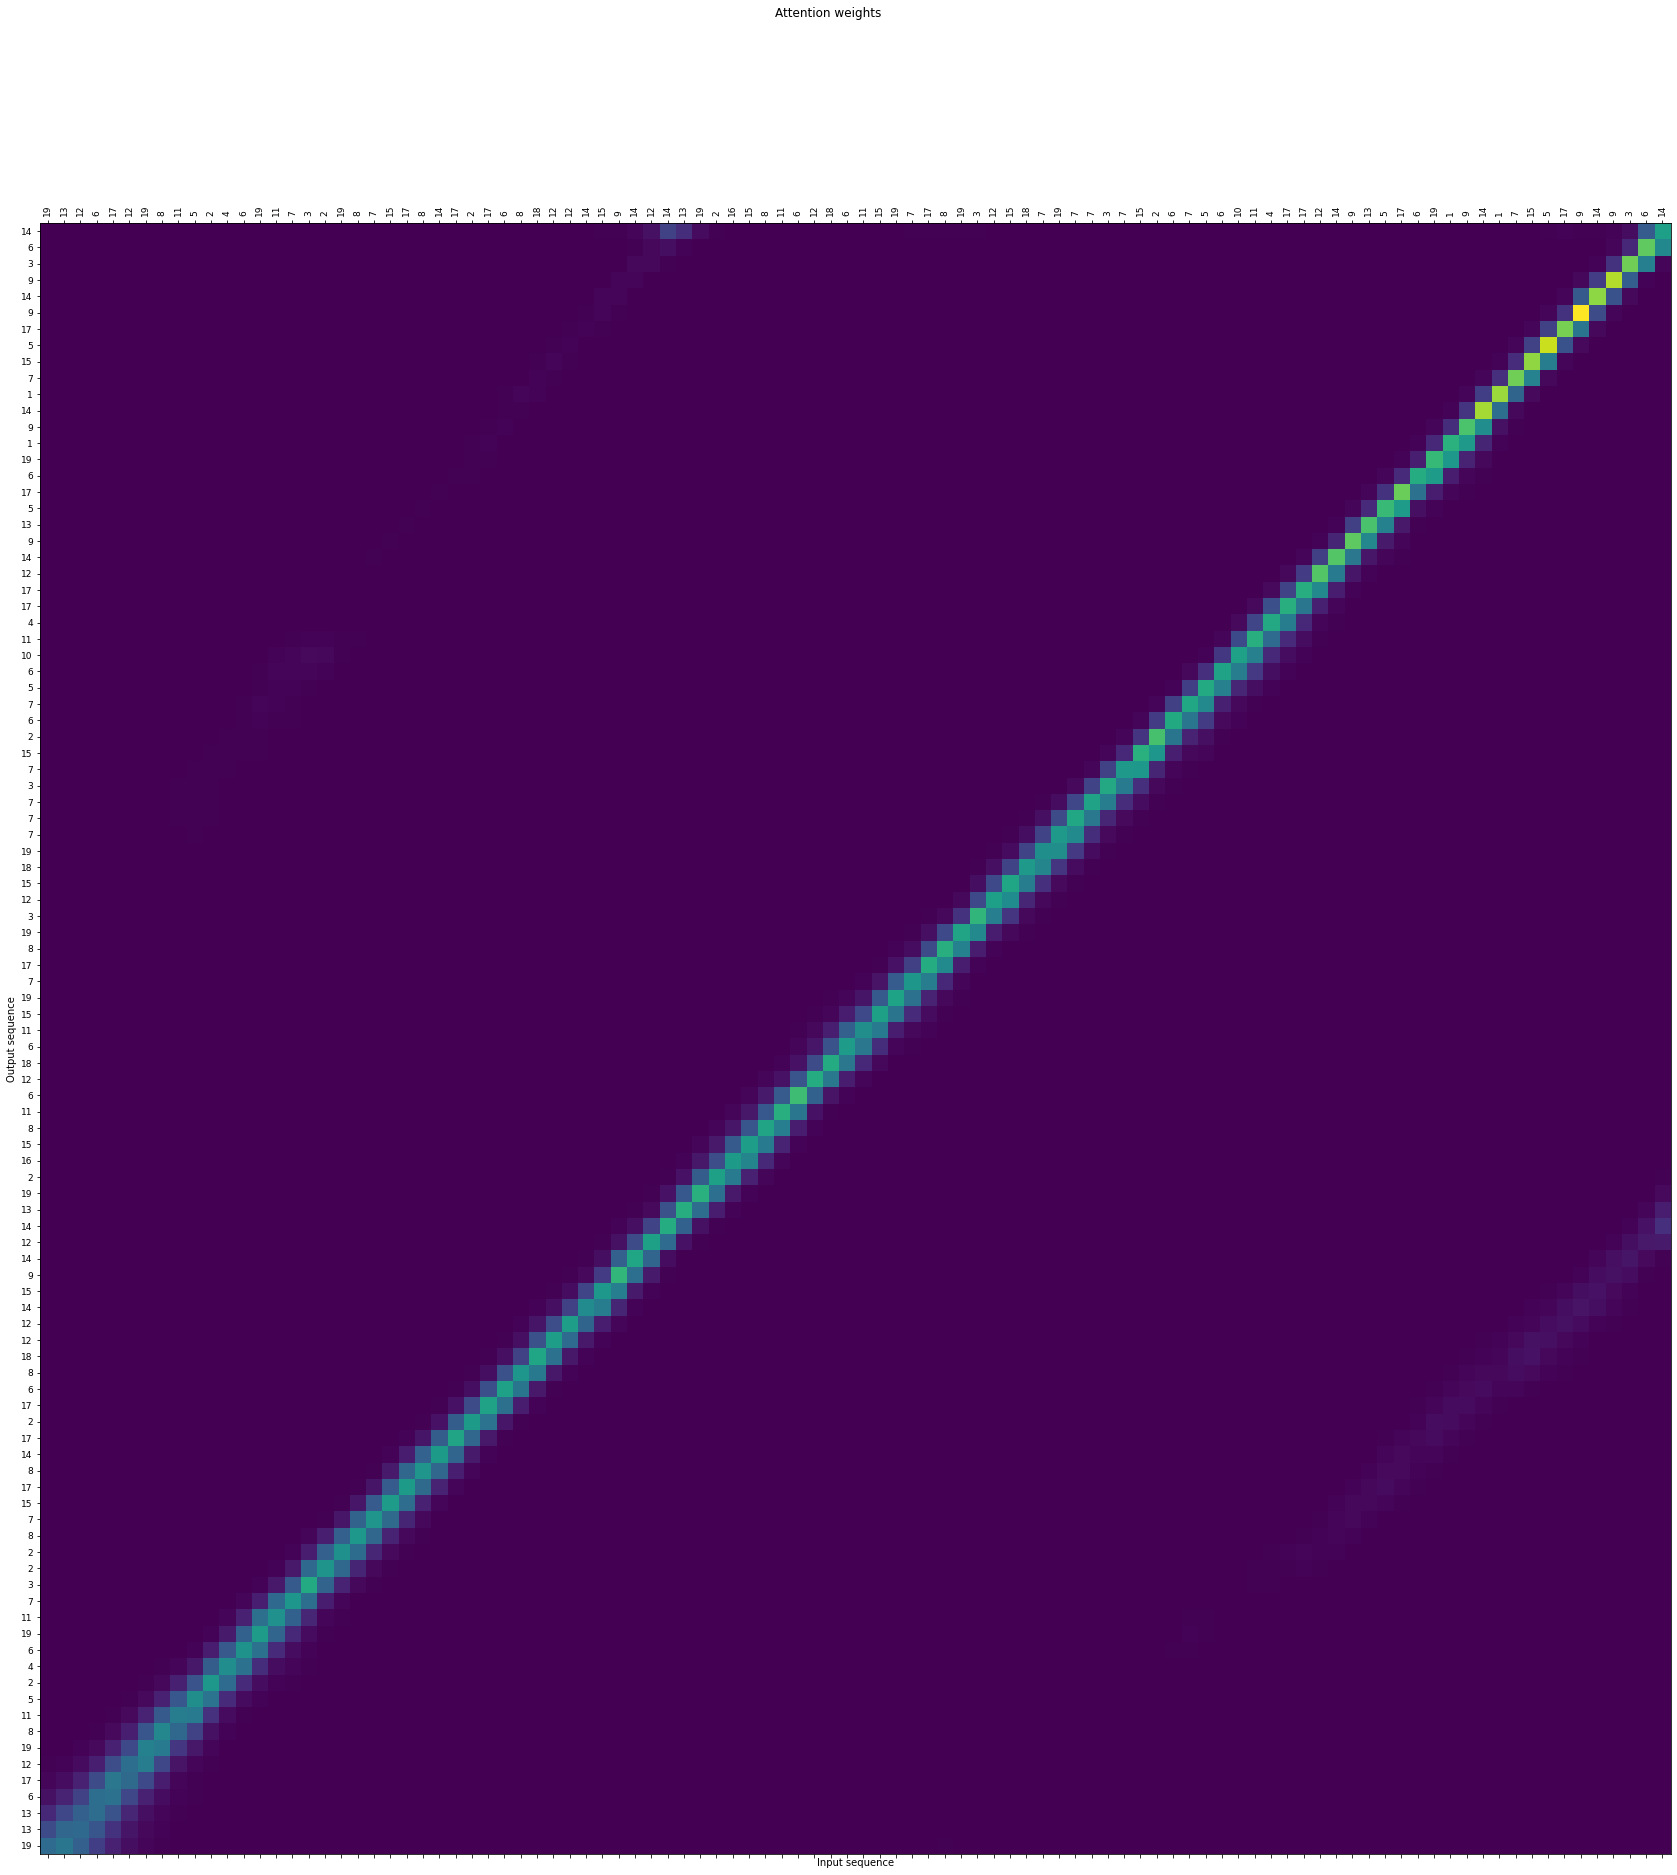

In [17]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

## Luong General attention

In [18]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()

        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(self.W(values), perm=[0, 2, 1])

        score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed), perm=[0, 2, 1])
        
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Training parameters:
- Batch size: 100
- RNN units: 100
- Attention units: 100

In [19]:
# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
# The number of units has to be the same as the number of units of the RNN
attention = LuongGeneralAttention(rnn_units)
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 141s 2s/step - loss: 2.9670 - accuracy: 0.0549 - val_loss: 2.9503 - val_accuracy: 0.0545
Epoch 2/50
18/18 [==============================] - 4s 213ms/step - loss: 2.9454 - accuracy: 0.0573 - val_loss: 2.9444 - val_accuracy: 0.0549
Epoch 3/50
18/18 [==============================] - 4s 200ms/step - loss: 2.9419 - accuracy: 0.0628 - val_loss: 2.9409 - val_accuracy: 0.0691
Epoch 4/50
18/18 [==============================] - 4s 199ms/step - loss: 2.9334 - accuracy: 0.0707 - val_loss: 2.9290 - val_accuracy: 0.0749
Epoch 5/50
18/18 [==============================] - 4s 201ms/step - loss: 2.9248 - accuracy: 0.0774 - val_loss: 2.9224 - val_accuracy: 0.0804
Epoch 6/50
18/18 [==============================] - 4s 202ms/step - loss: 2.9157 - accuracy: 0.0825 - val_loss: 2.9138 - val_accuracy: 0.0843
Epoch 7/50
18/18 [==============================] - 4s 200ms/step - loss: 2.9077 - accuracy: 0.0859 - val_loss: 2.9017 - val_accuracy: 0.0891
Epoch 8

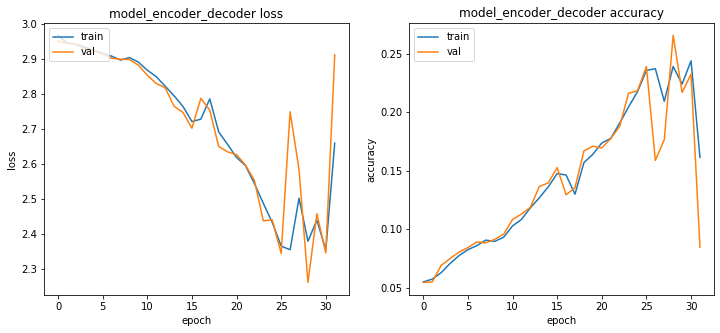

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [3, 14, 14, 14, 14, 14, 9, 9, 9, 9, 14, 14, 14, 14, 14, 14, 5, 5, 17, 17, 17, 17, 17, 17, 17, 4, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 12, 19, 19, 17, 17, 17, 19, 19, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 19, 14, 14, 14, 14, 14, 14, 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


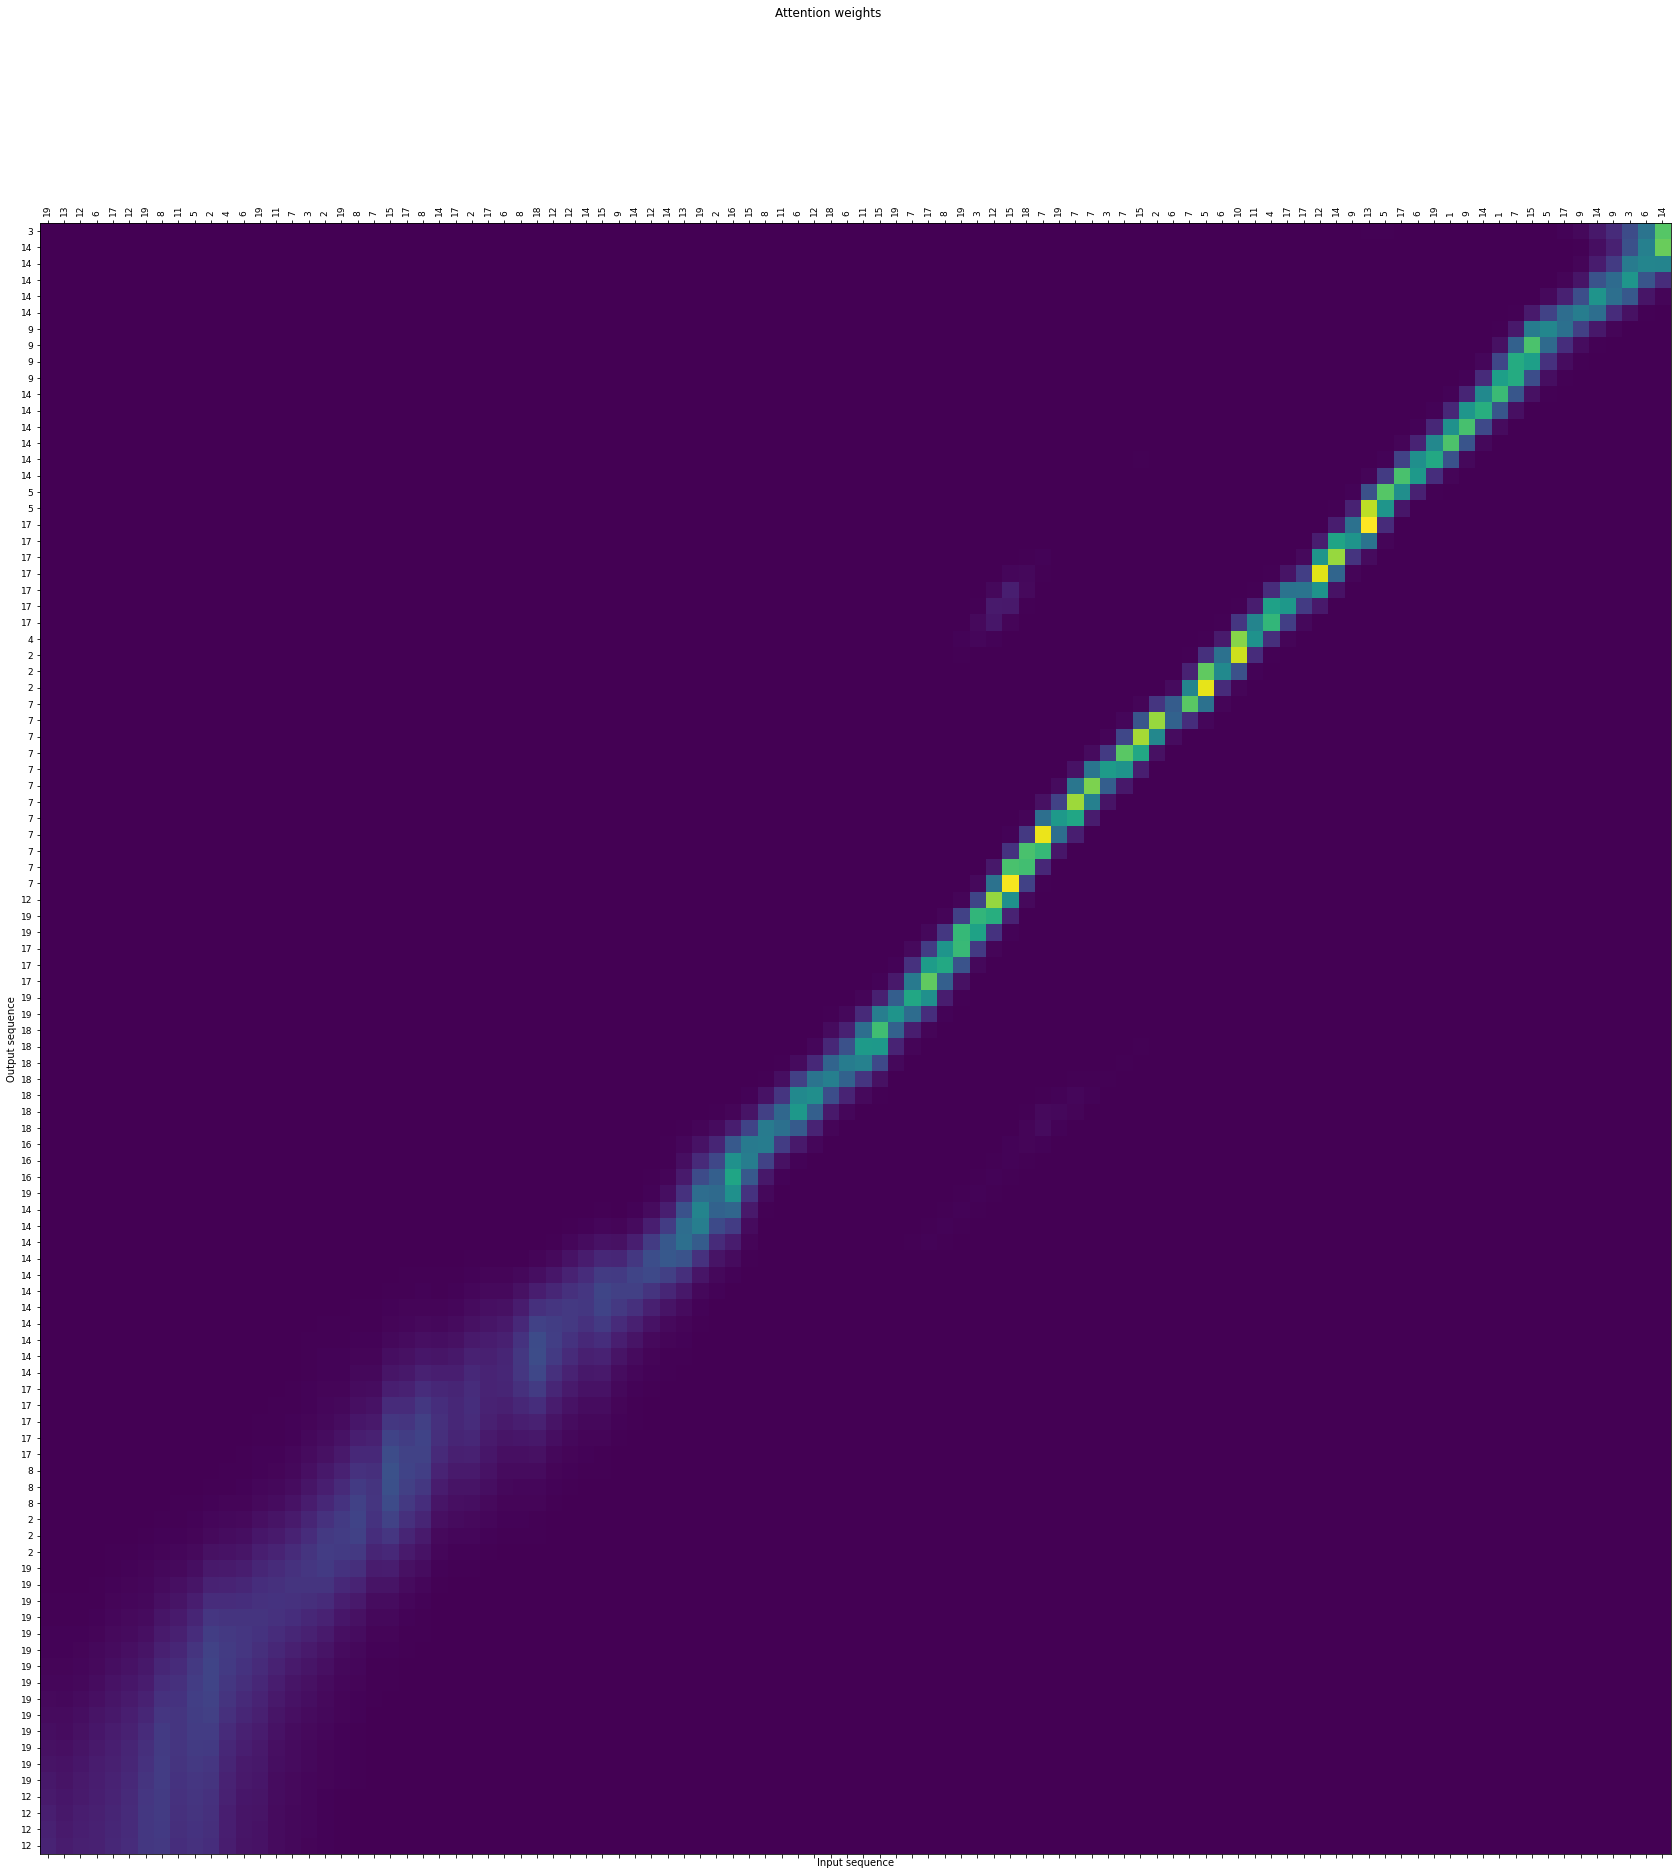

In [20]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

Training parameters:
- Batch size: 50
- RNN units: 50
- Attention units: 50

In [21]:
# training parameters
batch_size = 50

# model parameters
rnn_units = 50

# attention model
# The number of units has to be the same as the number of units of the RNN
attention = LuongGeneralAttention(rnn_units)
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
36/36 [==============================] - 144s 1s/step - loss: 2.9625 - accuracy: 0.0530 - val_loss: 2.9468 - val_accuracy: 0.0563
Epoch 2/50
36/36 [==============================] - 7s 191ms/step - loss: 2.9451 - accuracy: 0.0579 - val_loss: 2.9437 - val_accuracy: 0.0609
Epoch 3/50
36/36 [==============================] - 7s 197ms/step - loss: 2.9398 - accuracy: 0.0638 - val_loss: 2.9349 - val_accuracy: 0.0680
Epoch 4/50
36/36 [==============================] - 8s 208ms/step - loss: 2.9305 - accuracy: 0.0721 - val_loss: 2.9269 - val_accuracy: 0.0730
Epoch 5/50
36/36 [==============================] - 7s 193ms/step - loss: 2.9206 - accuracy: 0.0782 - val_loss: 2.9155 - val_accuracy: 0.0809
Epoch 6/50
36/36 [==============================] - 7s 196ms/step - loss: 2.9096 - accuracy: 0.0845 - val_loss: 2.9043 - val_accuracy: 0.0868
Epoch 7/50
36/36 [==============================] - 7s 194ms/step - loss: 2.8965 - accuracy: 0.0904 - val_loss: 2.8917 - val_accuracy: 0.0931
Epoch 8

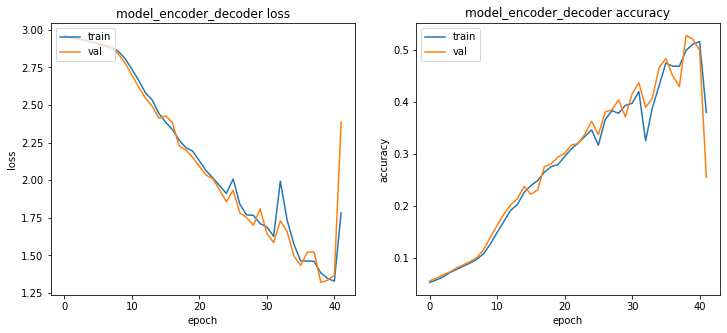

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [14, 6, 6, 9, 9, 9, 17, 5, 5, 7, 1, 14, 1, 9, 9, 6, 5, 5, 13, 9, 14, 14, 17, 17, 17, 11, 10, 10, 6, 7, 7, 7, 2, 7, 7, 7, 7, 19, 7, 18, 15, 3, 3, 19, 19, 19, 17, 17, 15, 8, 6, 6, 6, 12, 11, 8, 15, 16, 16, 19, 19, 14, 14, 14, 14, 9, 15, 12, 12, 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


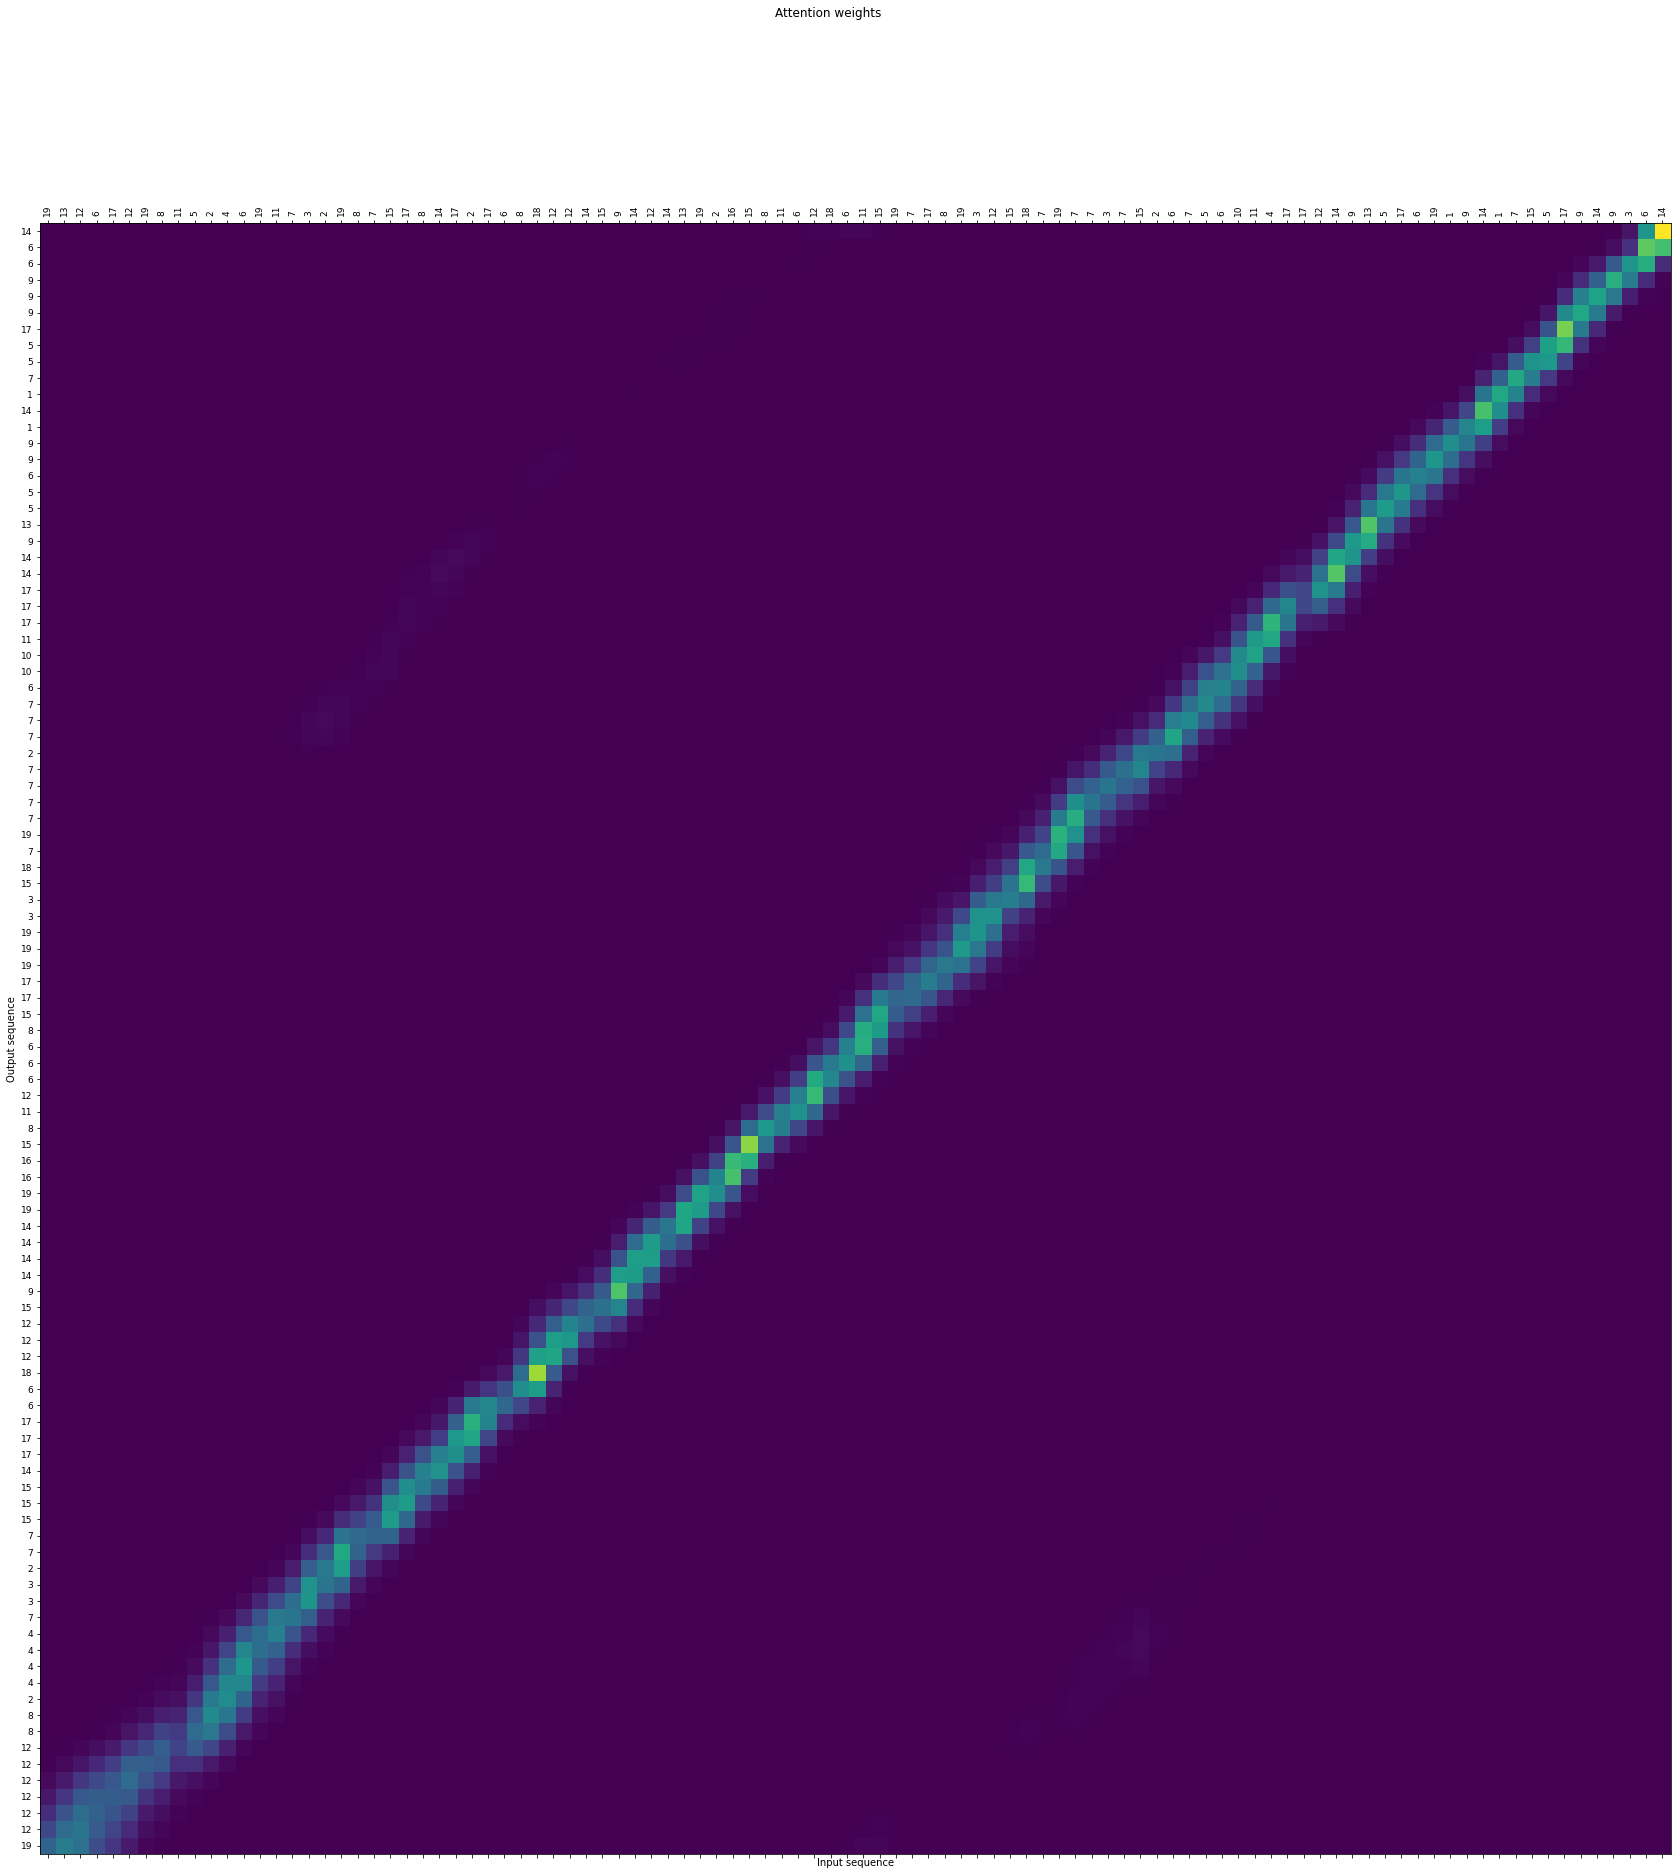

In [22]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

Training parameters:
- Batch size: 20
- RNN units: 100
- Attention units: 100

In [23]:
# training parameters
batch_size = 20

# model parameters
rnn_units = 100

# attention model
# The number of units has to be the same as the number of units of the RNN
attention = LuongGeneralAttention(rnn_units)
model = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/50
90/90 [==============================] - 155s 526ms/step - loss: 2.9460 - accuracy: 0.0612 - val_loss: 2.9275 - val_accuracy: 0.0768
Epoch 2/50
90/90 [==============================] - 17s 194ms/step - loss: 2.9098 - accuracy: 0.0845 - val_loss: 2.8909 - val_accuracy: 0.0920
Epoch 3/50
90/90 [==============================] - 17s 191ms/step - loss: 2.8623 - accuracy: 0.1041 - val_loss: 2.8072 - val_accuracy: 0.1234
Epoch 4/50
90/90 [==============================] - 17s 192ms/step - loss: 2.7034 - accuracy: 0.1538 - val_loss: 2.5737 - val_accuracy: 0.1855
Epoch 5/50
90/90 [==============================] - 17s 192ms/step - loss: 2.4547 - accuracy: 0.2123 - val_loss: 2.3438 - val_accuracy: 0.2380
Epoch 6/50
90/90 [==============================] - 17s 193ms/step - loss: 2.2211 - accuracy: 0.2621 - val_loss: 2.0210 - val_accuracy: 0.3070
Epoch 7/50
90/90 [==============================] - 17s 192ms/step - loss: 2.1613 - accuracy: 0.2742 - val_loss: 2.0284 - val_accuracy: 0.297

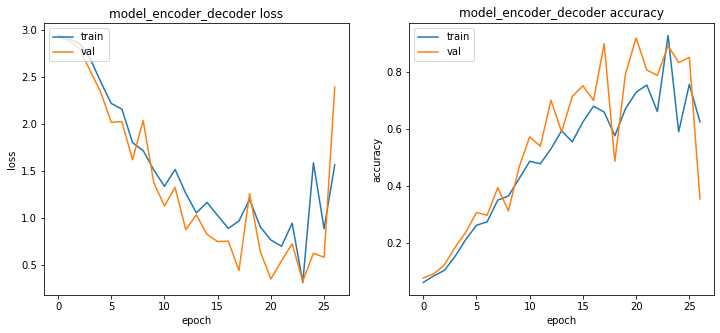

Input sequence: [19, 13, 12, 6, 17, 12, 19, 8, 11, 5, 2, 4, 6, 19, 11, 7, 3, 2, 19, 8, 7, 15, 17, 8, 14, 17, 2, 17, 6, 8, 18, 12, 12, 14, 15, 9, 14, 12, 14, 13, 19, 2, 16, 15, 8, 11, 6, 12, 18, 6, 11, 15, 19, 7, 17, 8, 19, 3, 12, 15, 18, 7, 19, 7, 7, 3, 7, 15, 2, 6, 7, 5, 6, 10, 11, 4, 17, 17, 12, 14, 9, 13, 5, 17, 6, 19, 1, 9, 14, 1, 7, 15, 5, 17, 9, 14, 9, 3, 6, 14]
Expected output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 2, 19, 13, 14, 12, 14, 9, 15, 14, 12, 12, 18, 8, 6, 17, 2, 17, 14, 8, 17, 15, 7, 8, 19, 2, 3, 7, 11, 19, 6, 4, 2, 5, 11, 8, 19, 12, 17, 6, 12, 13, 19]
Model output: [14, 6, 3, 9, 14, 9, 17, 5, 15, 7, 1, 14, 9, 1, 19, 6, 17, 5, 13, 9, 14, 12, 17, 17, 4, 11, 10, 6, 5, 7, 6, 2, 15, 7, 3, 7, 7, 19, 7, 18, 15, 12, 3, 19, 8, 17, 7, 19, 15, 11, 6, 18, 12, 6, 11, 8, 15, 16, 19, 19, 13, 14, 12, 14, 9, 15, 14, 12, 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator


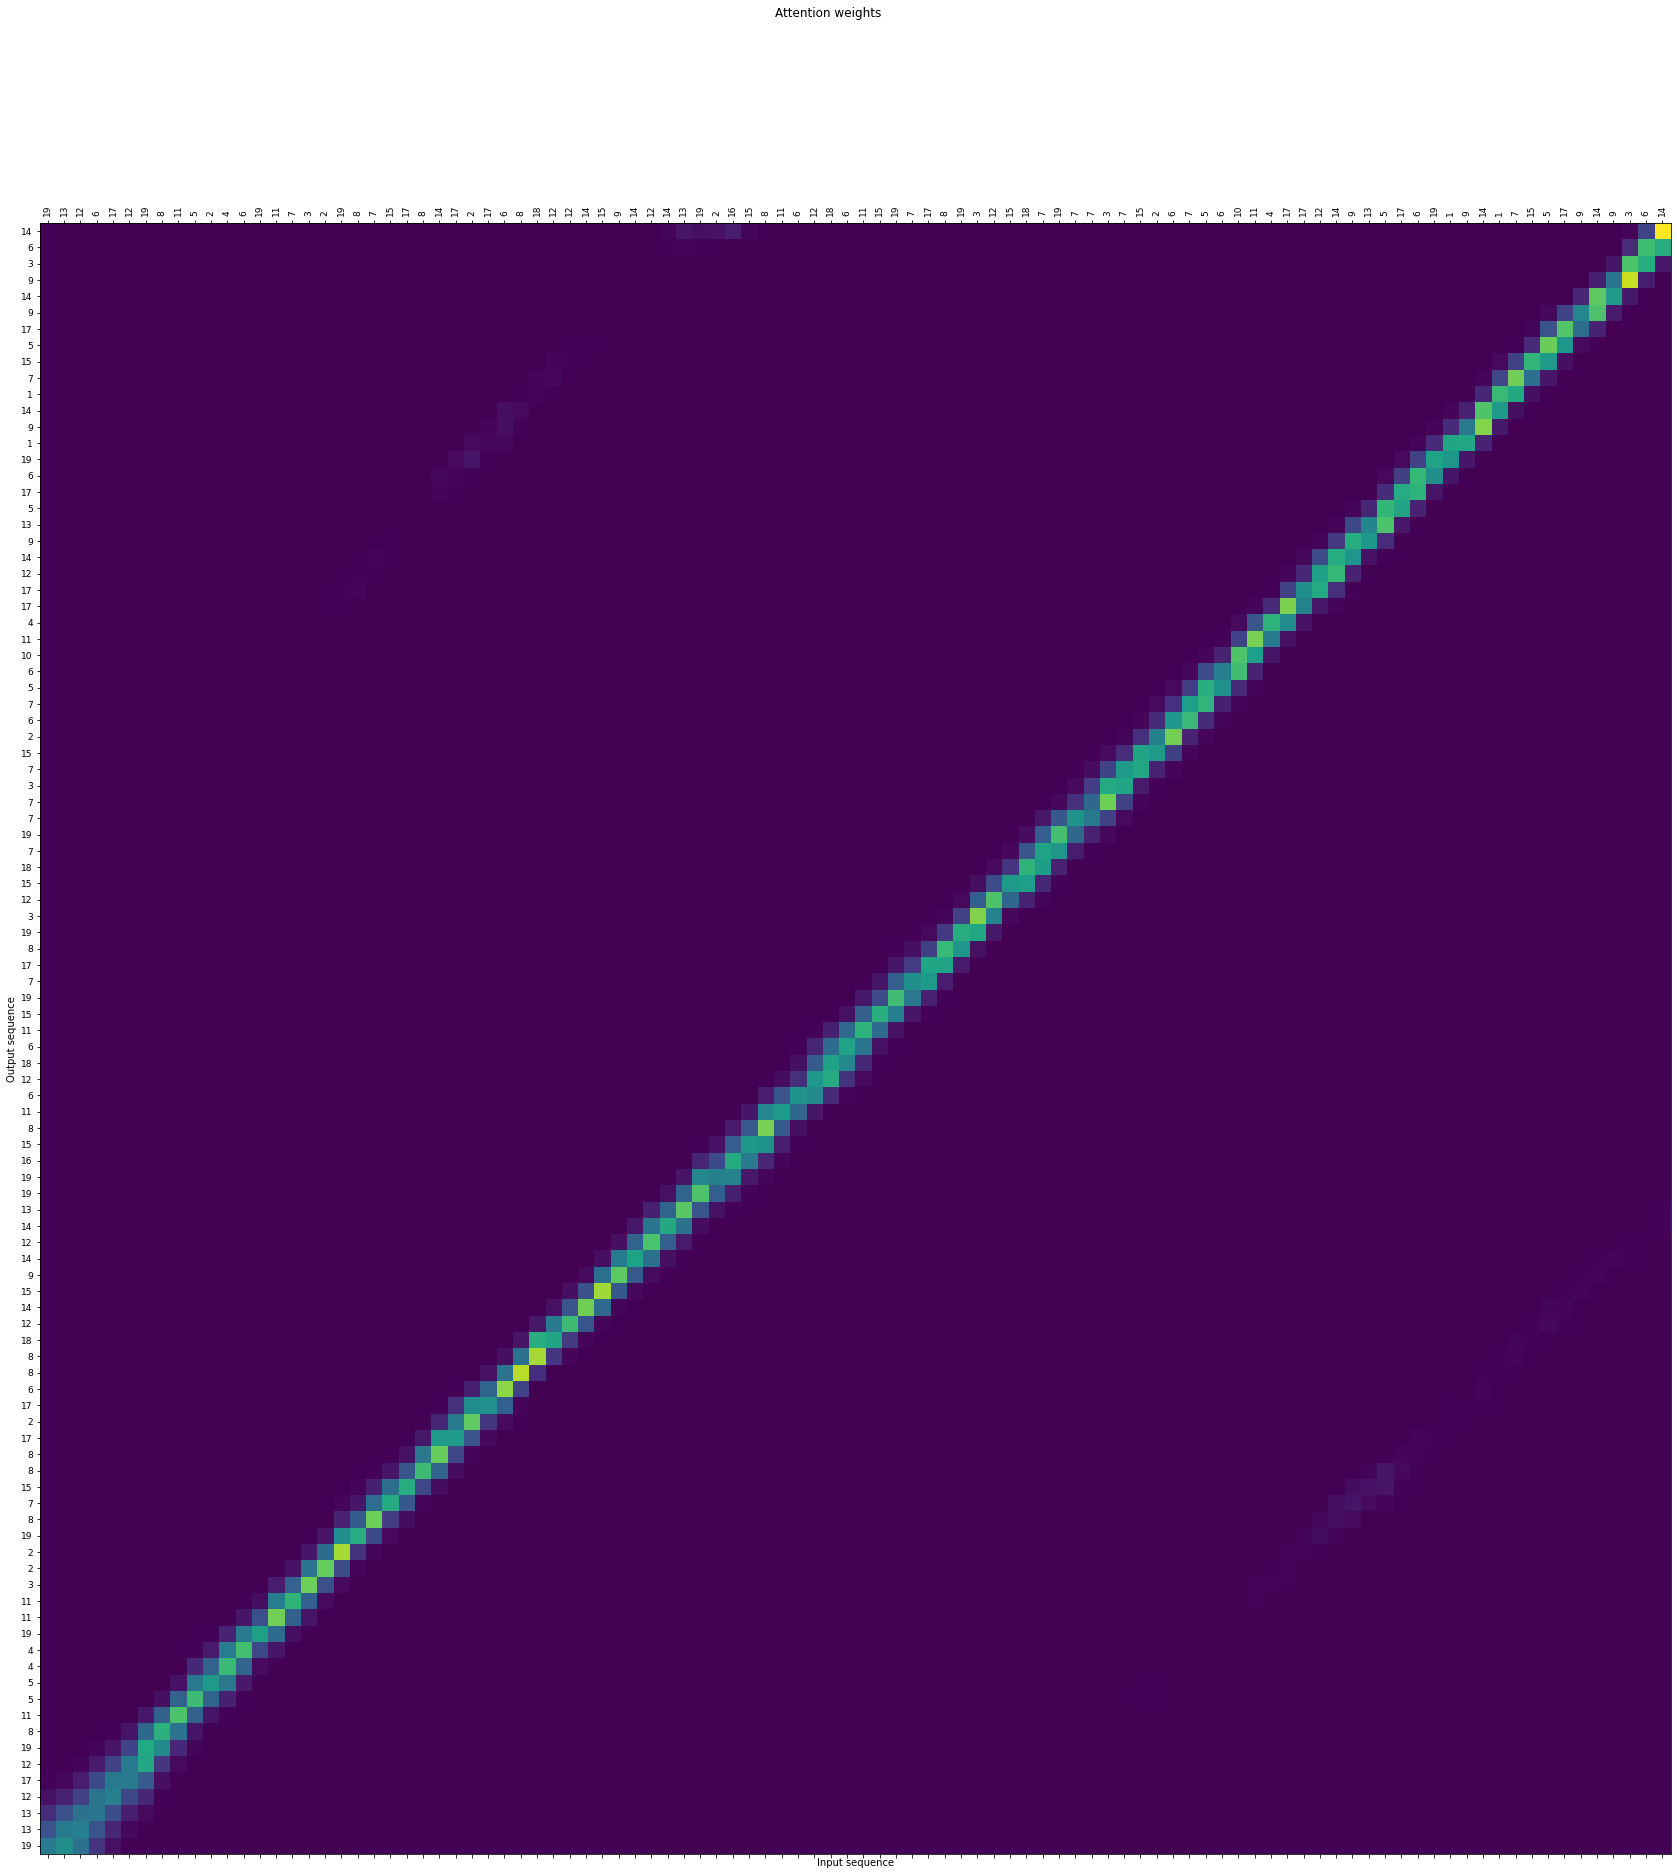

In [24]:
# Train the model
train_test(model, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

# Evaluate the model
evaluate_plot_attention(example_sequence, attention, model)

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.



We have performed some experiments in order to see how each one of the attention mechanisms behaves under different circumstances. For each one of them, we have created three different models changing some of the parameters. Mainly, for all of the attention mechanism we have tried three different batch sizes: 20, 50 and 100. For the Luong Dot Attention we have tried two different sizes for the two LSTMs: 80 and 100 neurons. For the Bahdanau Attention, we have also tried with a different number of units for the $W$ matrices. In this case, we have tried with 40 and 50. The number of neurons of the LSTMs has remained unchanged from the original values (100 neurons). Finally, for the Loung General Attention, we have tried 50 and 100 neurons for the LSTMs. Something that we have noticed is that the number of units of the attention layer had to match the number of units of the LSTMs.

In order to perform the experiments, we have created a dataset containing 2000 training sequences and 200 test sequences. Each sequence consists of 100 randomly generated numbers in the range $[0, 19]$. For each experiment we have used the `train_test` function to report the accuracy in both training and test. We have also reported the number of epochs that it takes for the models to converge. Finally, in order to see the inner workings of the models, we have generated a random example sequence which we have passed to the model using the `evaluate` function, which returns the attention weights at each step of the decoding process. We have plotted them to have a better visualization of what each models pays attention to when generating each one of the elements of the output sequence.

The obtained results can be seen in the table below:

| Attention mechanism | Model parameters | Batch size | Train accuracy (%) | Test accuracy (%) | Epochs |
|---------------------|------------------|-----------:|-------------------:|------------------:|-------:|
| **Luong Dot** | LSTMs: 100 units | 100 | 26.071 | 26.025 | 24 |
| **Luong Dot** | LSTMs: 100 units | 50 | 41.871 | 41.300 | 22 |
| **Luong Dot** | LSTMs: 80 units | 20 | 86.387 | 85.675 | 17 |
| **Bahdanau** | LSTMs: 100 units, Attention: 50 units | 100 | 22.545 | 22.575 | 24 |
| **Bahdanau** | LSTMs: 100 units, Attention: 50 units | 100 | 32.482 | 32.420 | 18 |
| **Bahdanau** | LSTMs: 100 units, Attention: 40 units | 100 | 92.426 | 92.205 | 27 |
| **Luong General** | LSTMs: 100 units, Attention: 100 units | 100 | 26.629 | 26.425 | 32 |
| **Luong General** | LSTMs: 50 units, Attention: 50 units | 50 | 53.868 | 52.890 | 42 |
| **Luong General** | LSTMs: 100 units, Attention: 100 units | 20 | 89.342 | 88.730 | 27 |

We can clearly see that the results actually improve as we reduce the batch size. Considering the fact that we are dealing with sequences of length 100, it makes sense to use smaller batches and to update the model more frequently. In general, we can see that the attention mechanism that converges the fastest is the **Luong Dot** attention, which is not surprising at all considering that the attention mechanism doesn't have any parameter. On the contrary, the **Luong General** is the attention mechanism that takes more epochs to converge on average. The **Bahdanau** attention mechanism is in a mid tier between the two previous mechanisms. When using batches of size 20, all the attention mechanisms show the best results. However, the best one in this case is the Bahdanau attention mechanism, since it obtains the best accuracy on both training and test. The Luong General mechanism comes in second place, and it is closely followed by the Dot mechanism.

In general, the accuracies vary a lot between executions, mainly because the dataset is randomly generated each time. In most cases, the Luong Dot mechanism outperforms the other two. However, in this case it falls short compared to them. Therefore, it is hard to draw a conclusion on which is the best attention mechanism among the three that we have tested, because some other factors might come into play (initialization of the models, the task that we are performing, etc.). The only thing that we can tell for sure is that smaller batches yield better overall results, both in accuracies and epochs needed to converge. The rest depends on how much we test each method and how much we fine-tune them.

If we observe the plots of the attention weights, we can see that they are not perfectly anti-diagonal (a diagonal going from the upper right corner to the bottom left one). Some of the adjacent entries of the anti-diagonal also contribute to the outputs because their attention weights are non-zero. The less accurate the model, the wider the anti-diagonal is and more elements of the sequence receive attention. Also, in some cases, there are some short lines which are parallel to the anti-diagonal, which is especially evident in the less accurate models. For example, if we take the plot of the best model, we can see that it has almost a perfect anti-diagonal, although there are still some adjacent elements that receive some attention. If we take a look at some of the worst models, we can see that the anti-diagonal is quite wide and that there are some parallel lines. Something that is really interesting is that for all the models (even for the best one), the last elements of the output sequence are the hardest ones to get right. This is because the attention is spread among many elements and there is not any element that gets the most attention among them. Considering that these output elements are related to the first ones of the input sequence, this could mean that the models have some sort of long-term memory issues for sequences this long, be it because of the attention mechanisms or because the models fall short or need some extra fine-tuning.

# Blog post

An explanation on what attention is, what kinds of attention mechanisms are there and how they work can be found [here](https://hackmd.io/@Volokin/BJqL6Xr2F).